#### **SGPT Utils**

This notebook contains various utils for the SGPT repo.

Author: Niklas Muennighoff

##### Tweet Extraction

In [ ]:
%%writefile scrape_tweets.py
'''
The following is a basic twitter scraper code using tweepy.
We preprocess the text - 1. Remove Emojis 2. Remove urls from the tweet.
We store the output tweets with tweet-id and tweet-text in each line tab seperated.
You will need to have an active Twitter account and provide your consumer key, secret and a callback url.
You can get your keys from here: https://developer.twitter.com/en/portal/projects-and-apps
Twitter by default implements rate limiting of scraping tweets per hour: https://developer.twitter.com/en/docs/twitter-api/rate-limits
Default limits are 300 calls (in every 15 mins).
Install tweepy (pip install tweepy) to run the code below.
python scrape_tweets.py
'''

import tweepy
import csv
import pickle
import tqdm
import re

#### Twitter Account Details
consumer_key = 'consumer_key' # Your twitter consumer key
consumer_secret = 'consumer_secret' # Your twitter consumer secret
callback_url = 'callback_url' # callback url

#### Input/Output Details
input_file = "201509-tweet-ids.txt" # Tab seperated file containing twitter tweet-id in each line 
output_file = "201509-tweet-scraped-ids-test.txt" # output file which you wish to save

#/content/201509-tweet-ids.txt

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def de_emojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocessing(text):
    return re.sub(r"http\S+", "", de_emojify(text).replace("\n", "")).strip()

def update_tweet_dict(tweets, tweet_dict):
    for tweet in tweets:
        if tweet:
            try:
                idx = tweet.id_str.strip()
                tweet_dict[idx] = preprocessing(tweet.text)
            except:
                continue
    
    return tweet_dict

def write_dict_to_file(filename, dic):
    with open(filename, "w") as outfile:
        outfile.write("\n".join((idx + "\t" + text) for idx, text in dic.items()))

### Main Code starts here
auth = tweepy.OAuthHandler(consumer_key, consumer_secret, callback_url)
try:
    redirect_url = auth.get_authorization_url()
except tweepy.TweepError:
    print('Error! Failed to get request token.')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

all_tweets = []
tweets = []
tweet_dict = {}

reader = csv.reader(open(input_file, encoding="utf-8"), delimiter="\t", quoting=csv.QUOTE_NONE)
for row in reader:
    all_tweets.append(row[0])

generator = chunks(all_tweets, 100)
batches = int(len(all_tweets)/100)
total = batches if len(all_tweets) % 100 == 0 else batches + 1 

print("Retrieving Tweets...")
for idx, tweet_id_chunks in enumerate(tqdm.tqdm(generator, total=total)):

    if idx >= 300 and idx % 300 == 0: # Rate-limiting every 300 calls (in 15 mins)
        print("Preprocessing Text...")
        tweet_dict = update_tweet_dict(tweets, tweet_dict)
        write_dict_to_file(output_file, tweet_dict)
    
    tweets += api.statuses_lookup(id_=tweet_id_chunks, include_entities=True, trim_user=True, map=None)

print("Preprocessing Text...")
tweet_dict = update_tweet_dict(tweets, tweet_dict)
write_dict_to_file(output_file, tweet_dict)

Writing scrape_tweets.py


In [ ]:
!pip install tweepy

In [ ]:
!git clone https://github.com/igorbrigadir/newsir16-data.git
!mv newsir16-data/twitter/curated/201509-tweet-ids.txt.gz ./
!gunzip /content/201509-tweet-ids.txt.gz

Cloning into 'newsir16-data'...
remote: Enumerating objects: 111, done.
remote: Total 111 (delta 0), reused 0 (delta 0), pack-reused 111
Receiving objects: 100% (111/111), 33.47 MiB | 39.48 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [ ]:
!python scrape_tweets.py

Error! Failed to get request token.
Retrieving Tweets...
  1% 300/32741 [02:46<5:05:37,  1.77it/s]Preprocessing Text...
Rate limit reached. Sleeping for: 733
  2% 600/32741 [17:56<5:02:02,  1.77it/s]Preprocessing Text...
Rate limit reached. Sleeping for: 728
  3% 900/32741 [33:00<4:44:54,  1.86it/s]Preprocessing Text...
Rate limit reached. Sleeping for: 729
  4% 1200/32741 [48:02<4:24:44,  1.99it/s]Preprocessing Text...
Rate limit reached. Sleeping for: 732
  5% 1500/32741 [1:03:08<4:50:40,  1.79it/s]Preprocessing Text...
Rate limit reached. Sleeping for: 731
  5% 1800/32741 [1:18:15<4:51:50,  1.77it/s]Preprocessing Text...
Rate limit reached. Sleeping for: 729
  6% 2100/32741 [1:33:23<5:06:11,  1.67it/s]Preprocessing Text...
Rate limit reached. Sleeping for: 726
  7% 2400/32741 [1:48:32<4:45:49,  1.77it/s]Preprocessing Text...
Rate limit reached. Sleeping for: 721
  8% 2700/32741 [2:03:32<4:51:39,  1.72it/s]Preprocessing Text...
Rate limit reached. Sleeping for: 727
  9% 3000/32741 [2

##### Compute maximum possible reranking score

In [ ]:
# Get BM25 results from kaggle
!mkdir /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/

!kaggle datasets download -d beirbm25results
!unzip ./beirbm25results.zip

cp: cannot stat '/content/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open ./beirbm25results.zip, ./beirbm25results.zip.zip or ./beirbm25results.zip.ZIP.


In [ ]:
!kaggle datasets download -d signal1m
!unzip ./signal1m.zip

!kaggle datasets download -d muennighoff/trecnews
!unzip ./trecnews.zip

signal1m.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./signal1m.zip
replace signal1m/corpus.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: Warning: Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /root/.kaggle/kaggle.json'
trecnews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./trecnews.zip
replace trec-news/corpus.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!mv signal1m datasets/
!mv trec-news datasets/

In [ ]:
!kaggle datasets download -d muennighoff/trecnews
!unzip ./trec-news.zip

In [ ]:
!pip install -q beir

     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 78 kB 3.9 MB/s 
     |████████████████████████████████| 8.4 MB 26.2 MB/s 
     |████████████████████████████████| 379 kB 68.3 MB/s 
     |████████████████████████████████| 4.9 MB 43.3 MB/s 
     |████████████████████████████████| 3.1 MB 24.2 MB/s 
     |████████████████████████████████| 3.3 MB 18.5 MB/s 
     |████████████████████████████████| 1.2 MB 44.0 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 895 kB 48.1 MB/s 
     |████████████████████████████████| 596 kB 55.1 MB/s 


In [ ]:
from beir import util, LoggingHandler
import logging
# Code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

/usr/local/lib/python3.7/dist-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Example & Intuition

k = "1"

ex_results = {k: results_loaded[k]}
ex_rels = {k: qrels[k]}

corr_doc = list(qrels[k].keys())[0]

ndcg, _map, recall, precision = EvaluateRetrieval().evaluate(ex_rels, ex_results, [1, 10, 100, 1000])

print(corr_doc in results_loaded[k])

# >>> Score is 0, as the correct answer is nowhere in the results

max_val = max(ex_results["1"].values())
ex_results[k][corr_doc] = max_val + 1

ndcg, _map, recall, precision = EvaluateRetrieval().evaluate(ex_rels, ex_results, [1, 10, 100, 1000])
print(corr_doc in results_loaded[k])

# >>> Score is 1, as the correct answer has the highest score in the results

min_val = min(ex_results["1"].values())
ex_results[k][corr_doc] = max_val - min_val

ndcg, _map, recall, precision = EvaluateRetrieval().evaluate(ex_rels, ex_results, [1, 10, 100, 1000])
print(corr_doc in results_loaded[k])

# >>> Score is between 0 & 1, as the correct answer has a medium score in the results

2021-11-28 12:54:45 - 

2021-11-28 12:54:45 - NDCG@1: 0.0000
2021-11-28 12:54:45 - NDCG@10: 0.0000
2021-11-28 12:54:45 - NDCG@100: 0.0000
2021-11-28 12:54:45 - NDCG@1000: 0.0000
2021-11-28 12:54:45 - 

2021-11-28 12:54:45 - MAP@1: 0.0000
2021-11-28 12:54:45 - MAP@10: 0.0000
2021-11-28 12:54:45 - MAP@100: 0.0000
2021-11-28 12:54:45 - MAP@1000: 0.0000
2021-11-28 12:54:45 - 

2021-11-28 12:54:45 - Recall@1: 0.0000
2021-11-28 12:54:45 - Recall@10: 0.0000
2021-11-28 12:54:45 - Recall@100: 0.0000
2021-11-28 12:54:45 - Recall@1000: 0.0000
2021-11-28 12:54:45 - 

2021-11-28 12:54:45 - P@1: 0.0000
2021-11-28 12:54:45 - P@10: 0.0000
2021-11-28 12:54:45 - P@100: 0.0000
2021-11-28 12:54:45 - P@1000: 0.0000
False
2021-11-28 12:54:45 - 

2021-11-28 12:54:45 - NDCG@1: 1.0000
2021-11-28 12:54:45 - NDCG@10: 1.0000
2021-11-28 12:54:45 - NDCG@100: 1.0000
2021-11-28 12:54:45 - NDCG@1000: 1.0000
2021-11-28 12:54:45 - 

2021-11-28 12:54:45 - MAP@1: 1.0000
2021-11-28 12:54:45 - MAP@10: 1.0000
2021-11-28 12:5

In [ ]:
import json
import os

from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.search.lexical import BM25Search as BM25
from beir.retrieval.evaluation import EvaluateRetrieval

# Subselecting all available ones
datasets = ["scifact", "msmarco", "trec-covid", "nfcorpus", "nq", "hotpotqa", "fiqa", 
           "arguana", "webis-touche2020", "cqadupstack", "quora", "dbpedia-entity",
           "scidocs", "fever", "climate-fever"]

datasets = ["climate-fever", "signal1m", "trec-news"]

k_values = [1, 10]
max_rerank = 10 # In BEIR 100 documents are reranked for their rerank encoder benchmark

# Need to rerank min 100 for @100;
assert max_rerank >= max(k_values), "Max Rerank is too small for the sample scores to compute"

ndcgs = {}

def perfect_rerank(results, qrels, max_rerank):
    """
    qrels: Dict[str, Dict[str, int]]
    results: Dict[str, Dict[str, float]]
    """
    perfect_rerank_results = {}
    for qid in qrels:
        if qid in results:
            # Subselect max rerank items with highest score
            topk = sorted(results[qid].items(), key=lambda item: item[1], reverse=True)[:max_rerank]
            topk = [key_val_pair[0] for key_val_pair in topk]

            perfect_rerank_results[qid] = {doc: float(score) for doc, score in qrels[qid].items() if doc in topk}
        else:
            # CAUTION: Skipping as we do here inflates the results vs putting an empty list, as the score is ignored
            # It might be more appropriate to put an empty list, i.e. no results, i.e. worse total score
            # However it seems like the default in BEIR is not to do so - Also only one dataset is affected: NFCorpus
            logging.info(f"Skipping {qid}")
        # Adding all other results with lower ranks is unnecessary as NDCG ignores them anyways
        #extra_results = {doc: float(score) * 0.0001 for doc, score in results[qid].items() if doc not in perfect_rerank_results[qid]}
        #perfect_rerank_results[qid] = {**perfect_rerank_results[qid], **extra_results}

    return perfect_rerank_results

for i, dataset in enumerate(datasets):

    if not(os.path.exists(os.path.join(os.getcwd(), 'datasets', dataset))):
        url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
        out_dir = os.path.join(os.getcwd(), "datasets")
        data_path = util.download_and_unzip(url, out_dir)
        print("Dataset downloaded here: {}".format(data_path))
    # Load the dataset into BEIR
    data_path = f"datasets/{dataset}"
    # In the paper it says, BEIR used the dev set for msmarco
    split = "dev" if dataset == "msmarco" else "test"

    # cqadupstack - Contains several sub datasets
    if dataset == "cqadupstack":
        cqa_ndcgs, cqa_maps, cqa_recalls, cqa_precisions = [], [], [], []
        for sub_dataset in os.listdir(data_path):
            sub_data_path = f"datasets/{dataset}/{sub_dataset}"
            corpus, queries, qrels = GenericDataLoader(sub_data_path).load(split=split)
            with open(f"./results_{dataset}_{sub_dataset}.json", 'r') as fp:
                results_loaded = json.load(fp)
            
            perfect_rerank_results = perfect_rerank(results_loaded, qrels, max_rerank)

            with open(f"./beir_perfect_rerank_{max_rerank}_{dataset}_{sub_dataset}.json", 'w') as fp:
                json.dump(perfect_rerank_results, fp)

            ndcg, _map, recall, precision = EvaluateRetrieval.evaluate(qrels, perfect_rerank_results, k_values)

            cqa_ndcgs.append(ndcg)
            cqa_maps.append(_map)
            cqa_recalls.append(recall)
            cqa_precisions.append(precision)

        for (metric, group) in [(ndcg, cqa_ndcgs), (_map, cqa_maps), (recall, cqa_recalls), (precision, cqa_precisions)]:
            for k in metric.keys():
                metric[k] = sum([score[k] for score in group]) / len(group)

        logging.info("CQA Final")
        logging.info(f"{ndcg}")
        logging.info(f"{_map}")
        logging.info(f"{recall}")
        logging.info(f"{precision}")

    else:
        corpus, queries, qrels = GenericDataLoader(data_path).load(split=split)
        with open(f"./results_{dataset}.json", 'r') as fp:
            results_loaded = json.load(fp)
        perfect_rerank_results = perfect_rerank(results_loaded, qrels, max_rerank)
        ndcg, _map, recall, precision = EvaluateRetrieval.evaluate(qrels, perfect_rerank_results, k_values)
        with open(f"./beir_perfect_rerank_{max_rerank}_{dataset}.json", 'w') as fp:
            json.dump(perfect_rerank_results, fp)

    ndcgs[dataset] = ndcg

    # Cleanup if necessary
    if ("signal1m" not in data_path) and ("trec-news" not in data_path):
        !rm -r {data_path}
        !rm -r {data_path}.zip


/usr/local/lib/python3.7/dist-packages/beir/datasets/data_loader.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/5416593 [00:00<?, ?it/s]

  0%|          | 0/2866316 [00:00<?, ?it/s]

  0%|          | 0/594977 [00:00<?, ?it/s]

In [ ]:
# Compute scores based on results.json

import json
import os

from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.search.lexical import BM25Search as BM25
from beir.retrieval.evaluation import EvaluateRetrieval


def compute_result(results_path, data_path, top_k=100, k_values=[1, 3, 5, 10, 100]):
    """
    Args:
        results_path: Path to .json to read rerank results
        top_k: How many docs to rerank per query
        k_values: For how many docs per query to compute the scores
    """
    split = "dev" if dataset == "msmarco" else "test"
    corpus, queries, qrels = GenericDataLoader(data_path).load(split=split)
    
    with open(results_path, 'r') as fp:
        results = json.load(fp)
    
    ndcg, _map, recall, precision = EvaluateRetrieval.evaluate(qrels, results, k_values)

    return (ndcg, _map, recall, precision)


# All datasets
datasets = ["trec-covid", "webis-touche2020", "nfcorpus", "scifact", "fiqa", "dbpedia-entity",
            "nq", "hotpotqa", "quora", "fever", "climate-fever", "arguana", "msmarco", "scidocs", "cqadupstack",
            "signal1m", "trec-news"]

max_rerank = 10

results_prefix = "./"

scores_out_path = f"{results_prefix}beir_perfect_rerank_{max_rerank}_ndcgs.json"
ndcgs = {}

for i, dataset in enumerate(datasets):
    
    if not(os.path.exists(os.path.join(os.getcwd(), 'datasets', dataset))):
        url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
        out_dir = os.path.join(os.getcwd(), "datasets")
        data_path = util.download_and_unzip(url, out_dir)
        print("Dataset downloaded here: {}".format(data_path))
    data_path = f"datasets/{dataset}"

    if dataset == "cqadupstack":
        cqa_ndcgs, cqa_maps, cqa_recalls, cqa_precisions = [], [], [], []
        for sub_dataset in os.listdir(data_path):
            sub_data_path = f"datasets/{dataset}/{sub_dataset}"
            results_path = f"{results_prefix}beir_perfect_rerank_{max_rerank}_{dataset}_{sub_dataset}.json"
            assert os.path.exists(os.path.join(os.getcwd(), results_path)), f"Missing path: {results_path}"

            ndcg, _map, recall, precision = compute_result(results_path, sub_data_path)
            cqa_ndcgs.append(ndcg)
            cqa_maps.append(_map)
            cqa_recalls.append(recall)
            cqa_precisions.append(precision)

        for (metric, group) in [(ndcg, cqa_ndcgs), (_map, cqa_maps), (recall, cqa_recalls), (precision, cqa_precisions)]:
            for k in metric.keys():
                metric[k] = sum([score[k] for score in group]) / len(group)

    else:
        results_path = f"{results_prefix}beir_perfect_rerank_{max_rerank}_{dataset}.json"
        assert os.path.exists(os.path.join(os.getcwd(), results_path)), f"Missing path: {results_path}"
        ndcg, _map, recall, precision = compute_result(results_path, data_path)

    ndcgs[dataset] = ndcg

    # Cleanup if necessary
    if ("signal1m" not in data_path) and ("trec-news" not in data_path):
        !rm -r {data_path}
        !rm -r {data_path}.zip

with open(scores_out_path, 'w') as fp:
    json.dump(ndcgs, fp)

2021-11-28 17:10:37 - Loading faiss with AVX2 support.
2021-11-28 17:10:37 - Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2021-11-28 17:10:37 - Loading faiss.
2021-11-28 17:10:38 - Successfully loaded faiss.
2021-11-28 17:10:38 - Downloading trec-covid.zip ...


/content/datasets/trec-covid.zip:   0%|          | 0.00/70.5M [00:00<?, ?iB/s]

2021-11-28 17:10:44 - Unzipping trec-covid.zip ...
Dataset downloaded here: /content/datasets/trec-covid
2021-11-28 17:10:47 - Loading Corpus...


  0%|          | 0/171332 [00:00<?, ?it/s]

2021-11-28 17:10:50 - Loaded 171332 TEST Documents.
2021-11-28 17:10:50 - Doc Example: {'text': 'OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumonia, 14 (35%) with upper respiratory tract 

/content/datasets/webis-touche2020.zip:   0%|          | 0.00/217M [00:00<?, ?iB/s]

2021-11-28 17:11:02 - Unzipping webis-touche2020.zip ...
Dataset downloaded here: /content/datasets/webis-touche2020
2021-11-28 17:11:10 - Loading Corpus...


  0%|          | 0/382545 [00:00<?, ?it/s]

2021-11-28 17:11:17 - Loaded 382545 TEST Documents.
2021-11-28 17:11:17 - Doc Example: {'text': 'My opponent forfeited every round. None of my arguments were answered. I don’t like the idea of winning by default, but here we are.Tule: it’s good for students to get involved and address big issues like teen pregnancy. You need to be able to answer arguments like mine and not simply prepare for an abstinence-only type of response. You should also be aware that, in the U.S., condoms may be sold to minors in ANY state. A retailer who says it is illegal to sell you them is, frankly, wrong.', 'title': 'Contraceptive Forms for High School Students'}
2021-11-28 17:11:17 - Loading Queries...
2021-11-28 17:11:17 - Loaded 49 TEST Queries.
2021-11-28 17:11:17 - Query Example: Should teachers get tenure?
2021-11-28 17:11:18 - 

2021-11-28 17:11:18 - NDCG@1: 0.8571
2021-11-28 17:11:18 - NDCG@3: 0.7704
2021-11-28 17:11:18 - NDCG@5: 0.6615
2021-11-28 17:11:18 - NDCG@10: 0.4666
2021-11-28 17:11:18 - NDC

/content/datasets/nfcorpus.zip:   0%|          | 0.00/2.34M [00:00<?, ?iB/s]

2021-11-28 17:11:21 - Unzipping nfcorpus.zip ...
Dataset downloaded here: /content/datasets/nfcorpus
2021-11-28 17:11:21 - Loading Corpus...


  0%|          | 0/3633 [00:00<?, ?it/s]

2021-11-28 17:11:21 - Loaded 3633 TEST Documents.
2021-11-28 17:11:21 - Doc Example: {'text': 'Recent studies have suggested that statins, an established drug group in the prevention of cardiovascular mortality, could delay or prevent breast cancer recurrence but the effect on disease-specific mortality remains unclear. We evaluated risk of breast cancer death among statin users in a population-based cohort of breast cancer patients. The study cohort included all newly diagnosed breast cancer patients in Finland during 1995–2003 (31,236 cases), identified from the Finnish Cancer Registry. Information on statin use before and after the diagnosis was obtained from a national prescription database. We used the Cox proportional hazards regression method to estimate mortality among statin users with statin use as time-dependent variable. A total of 4,151 participants had used statins. During the median follow-up of 3.25 years after the diagnosis (range 0.08–9.0 years) 6,011 participants die

/content/datasets/scifact.zip:   0%|          | 0.00/2.69M [00:00<?, ?iB/s]

2021-11-28 17:11:24 - Unzipping scifact.zip ...
Dataset downloaded here: /content/datasets/scifact
2021-11-28 17:11:24 - Loading Corpus...


  0%|          | 0/5183 [00:00<?, ?it/s]

2021-11-28 17:11:24 - Loaded 5183 TEST Documents.
2021-11-28 17:11:24 - Doc Example: {'text': 'Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms. In the posterior limb of the internal capsule, the mean apparent diffusion coefficients at both times were similar (1.2 vers

/content/datasets/fiqa.zip:   0%|          | 0.00/17.1M [00:00<?, ?iB/s]

2021-11-28 17:11:29 - Unzipping fiqa.zip ...
Dataset downloaded here: /content/datasets/fiqa
2021-11-28 17:11:29 - Loading Corpus...


  0%|          | 0/57638 [00:00<?, ?it/s]

2021-11-28 17:11:30 - Loaded 57638 TEST Documents.
2021-11-28 17:11:30 - Doc Example: {'text': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything.", 'title': ''}
2021-11-28 17:11:30 - Loading Queries...
2021-11-28 17:11:30 - Loaded 648 TEST Queries.
2021-11-28 17:11:30 - Query Example: How to deposit a cheque issued to an associate in my business into my business account?
2021-11-28 17:11:30 - 

2021-11-28 17:11:30 - NDCG@1: 0.5015
2021-11-28 17:11:30 - NDCG@3: 0.3874
2021-11-28 17:11:30 - NDCG@5: 0.3697
2021-11-28 17:11:30 - NDCG@10: 0.3632
2021-11-28 17:11:30 - NDCG@100: 0.3627
202

/content/datasets/dbpedia-entity.zip:   0%|          | 0.00/610M [00:00<?, ?iB/s]

2021-11-28 17:12:14 - Unzipping dbpedia-entity.zip ...
Dataset downloaded here: /content/datasets/dbpedia-entity
2021-11-28 17:12:37 - Loading Corpus...


  0%|          | 0/4635922 [00:00<?, ?it/s]

2021-11-28 17:13:26 - Loaded 4635922 TEST Documents.
2021-11-28 17:13:26 - Doc Example: {'text': "Animalia is an illustrated children's book by Graeme Base. It was originally published in 1986, followed by a tenth anniversary edition in 1996, and a 25th anniversary edition in 2012. Over three million copies have been sold.   A special numbered and signed anniversary edition was also published in 1996, with an embossed gold jacket.", 'title': 'Animalia (book)'}
2021-11-28 17:13:26 - Loading Queries...
2021-11-28 17:13:26 - Loaded 400 TEST Queries.
2021-11-28 17:13:26 - Query Example: Szechwan dish food cuisine
2021-11-28 17:13:26 - 

2021-11-28 17:13:26 - NDCG@1: 0.6800
2021-11-28 17:13:26 - NDCG@3: 0.5504
2021-11-28 17:13:26 - NDCG@5: 0.4787
2021-11-28 17:13:26 - NDCG@10: 0.3974
2021-11-28 17:13:26 - NDCG@100: 0.3063
2021-11-28 17:13:26 - 

2021-11-28 17:13:26 - MAP@1: 0.1031
2021-11-28 17:13:26 - MAP@3: 0.1742
2021-11-28 17:13:26 - MAP@5: 0.1947
2021-11-28 17:13:26 - MAP@10: 0.2089
20

/content/datasets/nq.zip:   0%|          | 0.00/475M [00:00<?, ?iB/s]

2021-11-28 17:13:52 - Unzipping nq.zip ...
Dataset downloaded here: /content/datasets/nq
2021-11-28 17:14:06 - Loading Corpus...


  0%|          | 0/2681468 [00:00<?, ?it/s]

2021-11-28 17:14:31 - Loaded 2681468 TEST Documents.
2021-11-28 17:14:31 - Doc Example: {'text': "In accounting, minority interest (or non-controlling interest) is the portion of a subsidiary corporation's stock that is not owned by the parent corporation. The magnitude of the minority interest in the subsidiary company is generally less than 50% of outstanding shares, or the corporation would generally cease to be a subsidiary of the parent.[1]", 'title': 'Minority interest'}
2021-11-28 17:14:31 - Loading Queries...
2021-11-28 17:14:31 - Loaded 3452 TEST Queries.
2021-11-28 17:14:31 - Query Example: what is non controlling interest on balance sheet
2021-11-28 17:14:32 - 

2021-11-28 17:14:32 - NDCG@1: 0.5403
2021-11-28 17:14:32 - NDCG@3: 0.5143
2021-11-28 17:14:32 - NDCG@5: 0.5143
2021-11-28 17:14:32 - NDCG@10: 0.5143
2021-11-28 17:14:32 - NDCG@100: 0.5143
2021-11-28 17:14:32 - 

2021-11-28 17:14:32 - MAP@1: 0.4818
2021-11-28 17:14:32 - MAP@3: 0.5066
2021-11-28 17:14:32 - MAP@5: 0.506

/content/datasets/hotpotqa.zip:   0%|          | 0.00/624M [00:00<?, ?iB/s]

2021-11-28 17:15:00 - Unzipping hotpotqa.zip ...
Dataset downloaded here: /content/datasets/hotpotqa
2021-11-28 17:15:20 - Loading Corpus...


  0%|          | 0/5233329 [00:00<?, ?it/s]

2021-11-28 17:16:08 - Loaded 5233329 TEST Documents.
2021-11-28 17:16:08 - Doc Example: {'text': 'Anarchism is a political philosophy that advocates self-governed societies based on voluntary institutions. These are often described as stateless societies, although several authors have defined them more specifically as institutions based on non-hierarchical free associations. Anarchism holds the state to be undesirable, unnecessary and harmful.', 'title': 'Anarchism'}
2021-11-28 17:16:08 - Loading Queries...
2021-11-28 17:16:09 - Loaded 7405 TEST Queries.
2021-11-28 17:16:09 - Query Example: Were Scott Derrickson and Ed Wood of the same nationality?
2021-11-28 17:16:09 - 

2021-11-28 17:16:09 - NDCG@1: 0.8952
2021-11-28 17:16:09 - NDCG@3: 0.6896
2021-11-28 17:16:09 - NDCG@5: 0.6896
2021-11-28 17:16:09 - NDCG@10: 0.6896
2021-11-28 17:16:09 - NDCG@100: 0.6896
2021-11-28 17:16:09 - 

2021-11-28 17:16:09 - MAP@1: 0.4476
2021-11-28 17:16:09 - MAP@3: 0.6295
2021-11-28 17:16:09 - MAP@5: 0.6295

/content/datasets/quora.zip:   0%|          | 0.00/15.1M [00:00<?, ?iB/s]

2021-11-28 17:16:15 - Unzipping quora.zip ...
Dataset downloaded here: /content/datasets/quora
2021-11-28 17:16:15 - Loading Corpus...


  0%|          | 0/522931 [00:00<?, ?it/s]

2021-11-28 17:16:19 - Loaded 522931 TEST Documents.
2021-11-28 17:16:19 - Doc Example: {'text': 'What is the step by step guide to invest in share market in india?', 'title': ''}
2021-11-28 17:16:19 - Loading Queries...
2021-11-28 17:16:19 - Loaded 10000 TEST Queries.
2021-11-28 17:16:19 - Query Example: Which question should I ask on Quora?
2021-11-28 17:16:19 - 

2021-11-28 17:16:19 - NDCG@1: 0.9447
2021-11-28 17:16:19 - NDCG@3: 0.9233
2021-11-28 17:16:19 - NDCG@5: 0.9174
2021-11-28 17:16:19 - NDCG@10: 0.9138
2021-11-28 17:16:19 - NDCG@100: 0.9125
2021-11-28 17:16:19 - 

2021-11-28 17:16:19 - MAP@1: 0.8140
2021-11-28 17:16:19 - MAP@3: 0.8969
2021-11-28 17:16:19 - MAP@5: 0.9017
2021-11-28 17:16:19 - MAP@10: 0.9026
2021-11-28 17:16:19 - MAP@100: 0.9026
2021-11-28 17:16:19 - 

2021-11-28 17:16:19 - Recall@1: 0.8140
2021-11-28 17:16:19 - Recall@3: 0.8969
2021-11-28 17:16:19 - Recall@5: 0.9017
2021-11-28 17:16:19 - Recall@10: 0.9026
2021-11-28 17:16:19 - Recall@100: 0.9026
2021-11-28 17:1

/content/datasets/fever.zip:   0%|          | 0.00/1.15G [00:00<?, ?iB/s]

2021-11-28 17:17:06 - Unzipping fever.zip ...
Dataset downloaded here: /content/datasets/fever
2021-11-28 17:17:44 - Loading Corpus...


  0%|          | 0/5416568 [00:00<?, ?it/s]

2021-11-28 17:18:42 - Loaded 5416568 TEST Documents.
2021-11-28 17:18:42 - Doc Example: {'text': 'The following are the football ( soccer ) events of the year 1928 throughout the world .', 'title': '1928 in association football'}
2021-11-28 17:18:42 - Loading Queries...
2021-11-28 17:18:43 - Loaded 6666 TEST Queries.
2021-11-28 17:18:43 - Query Example: Ukrainian Soviet Socialist Republic was a founding participant of the UN.
2021-11-28 17:18:43 - 

2021-11-28 17:18:43 - NDCG@1: 0.8609
2021-11-28 17:18:43 - NDCG@3: 0.8258
2021-11-28 17:18:43 - NDCG@5: 0.8246
2021-11-28 17:18:43 - NDCG@10: 0.8243
2021-11-28 17:18:43 - NDCG@100: 0.8243
2021-11-28 17:18:43 - 

2021-11-28 17:18:43 - MAP@1: 0.8019
2021-11-28 17:18:43 - MAP@3: 0.8141
2021-11-28 17:18:43 - MAP@5: 0.8141
2021-11-28 17:18:43 - MAP@10: 0.8141
2021-11-28 17:18:43 - MAP@100: 0.8141
2021-11-28 17:18:43 - 

2021-11-28 17:18:43 - Recall@1: 0.8019
2021-11-28 17:18:43 - Recall@3: 0.8141
2021-11-28 17:18:43 - Recall@5: 0.8141
2021-11-28

/content/datasets/climate-fever.zip:   0%|          | 0.00/1.14G [00:00<?, ?iB/s]

2021-11-28 17:19:35 - Unzipping climate-fever.zip ...
Dataset downloaded here: /content/datasets/climate-fever
2021-11-28 17:20:10 - Loading Corpus...


  0%|          | 0/5416593 [00:00<?, ?it/s]

2021-11-28 17:21:04 - Loaded 5416593 TEST Documents.
2021-11-28 17:21:04 - Doc Example: {'text': 'The following are the football ( soccer ) events of the year 1928 throughout the world .', 'title': '1928 in association football'}
2021-11-28 17:21:04 - Loading Queries...
2021-11-28 17:21:04 - Loaded 1535 TEST Queries.
2021-11-28 17:21:04 - Query Example: Global warming is driving polar bears toward extinction
2021-11-28 17:21:04 - 

2021-11-28 17:21:04 - NDCG@1: 0.4612
2021-11-28 17:21:04 - NDCG@3: 0.2963
2021-11-28 17:21:04 - NDCG@5: 0.2805
2021-11-28 17:21:04 - NDCG@10: 0.2805
2021-11-28 17:21:04 - NDCG@100: 0.2805
2021-11-28 17:21:04 - 

2021-11-28 17:21:04 - MAP@1: 0.1957
2021-11-28 17:21:04 - MAP@3: 0.2316
2021-11-28 17:21:04 - MAP@5: 0.2318
2021-11-28 17:21:04 - MAP@10: 0.2318
2021-11-28 17:21:04 - MAP@100: 0.2318
2021-11-28 17:21:04 - 

2021-11-28 17:21:04 - Recall@1: 0.1957
2021-11-28 17:21:04 - Recall@3: 0.2316
2021-11-28 17:21:04 - Recall@5: 0.2318
2021-11-28 17:21:04 - Recall

/content/datasets/arguana.zip:   0%|          | 0.00/3.60M [00:00<?, ?iB/s]

2021-11-28 17:21:11 - Unzipping arguana.zip ...
Dataset downloaded here: /content/datasets/arguana
2021-11-28 17:21:11 - Loading Corpus...


  0%|          | 0/8674 [00:00<?, ?it/s]

2021-11-28 17:21:11 - Loaded 8674 TEST Documents.
2021-11-28 17:21:11 - Doc Example: {'text': "You don’t have to be vegetarian to be green. Many special environments have been created by livestock farming – for example chalk down land in England and mountain pastures in many countries. Ending livestock farming would see these areas go back to woodland with a loss of many unique plants and animals. Growing crops can also be very bad for the planet, with fertilisers and pesticides polluting rivers, lakes and seas. Most tropical forests are now cut down for timber, or to allow oil palm trees to be grown in plantations, not to create space for meat production.  British farmer and former editor Simon Farrell also states: “Many vegans and vegetarians rely on one source from the U.N. calculation that livestock generates 18% of global carbon emissions, but this figure contains basic mistakes. It attributes all deforestation from ranching to cattle, rather than logging or development. It also m

  0%|          | 0/8841823 [00:00<?, ?it/s]

2021-11-28 17:23:15 - Loaded 8841823 DEV Documents.
2021-11-28 17:23:15 - Doc Example: {'text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.', 'title': ''}
2021-11-28 17:23:15 - Loading Queries...
2021-11-28 17:23:17 - Loaded 6980 DEV Queries.
2021-11-28 17:23:17 - Query Example: how many years did william bradford serve as governor of plymouth colony?
2021-11-28 17:23:18 - 

2021-11-28 17:23:18 - NDCG@1: 0.3888
2021-11-28 17:23:18 - NDCG@3: 0.3833
2021-11-28 17:23:18 - NDCG@5: 0.3833
2021-11-28 17:23:18 - NDCG@10: 0.3833
2021-11-28 17:23:18 - NDCG@100: 0.3833
2021-11-28 17:23:18 - 

2021-11-28 17:23:18 - MAP@1: 0.3777
2021-11-28 17:23:18 - MAP@3: 0.3817
2021-11-28 17:23:18 - MAP@5: 0.3817
2021-11-28 17:23:18

/content/datasets/scidocs.zip:   0%|          | 0.00/136M [00:00<?, ?iB/s]

2021-11-28 17:23:30 - Unzipping scidocs.zip ...
Dataset downloaded here: /content/datasets/scidocs
2021-11-28 17:23:33 - Loading Corpus...


  0%|          | 0/25657 [00:00<?, ?it/s]

2021-11-28 17:23:35 - Loaded 25657 TEST Documents.
2021-11-28 17:23:35 - Doc Example: {'text': 'An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks using a new evolutionary learning algorithm is proposed in this paper. This new evolutionary learning algorithm is based on a hybrid of genetic algorithm (GA) and particle swarm optimization (PSO), and is thus called HGAPSO. In HGAPSO, individuals in a new generation are created, not only by crossover and mutation operation as in GA, but also by PSO. The concept of elite strategy is adopted in HGAPSO, where the upper-half of the best-performing individuals in a population are regarded as elites. However, instead of being reproduced directly to the next generation, these elites are first enhanced. The group constituted by the elites is regarded as a swarm, and each elite corresponds to a particle within it. In this regard, the elites are enhanced by PSO, an operation which mimics the maturing pheno

/content/datasets/cqadupstack.zip:   0%|          | 0.00/4.98G [00:00<?, ?iB/s]

2021-11-28 17:26:55 - Unzipping cqadupstack.zip ...
Dataset downloaded here: /content/datasets/cqadupstack
2021-11-28 17:31:01 - Loading Corpus...


  0%|          | 0/37637 [00:00<?, ?it/s]

2021-11-28 17:31:02 - Loaded 37637 TEST Documents.
2021-11-28 17:31:02 - Doc Example: {'text': "There is a satellite image it's size is 10 GB and I need to display this image using GeoServer and OpenLayers. When user select the Satellite image in the layer switcher need to display image within 10 seconds. I tried geopdf but the image quality loss isn't acceptable to customer. I want to achieve 10 seconds response time using 32 GB satellite image. Please advice me how to achieve this? Thanks in advance.", 'title': 'Satellite image display with the help of GeoServer and OpenLayers'}
2021-11-28 17:31:02 - Loading Queries...
2021-11-28 17:31:10 - Loaded 885 TEST Queries.
2021-11-28 17:31:10 - Query Example: Calculating mean upslope aspect from each cell in DEM using Python?
2021-11-28 17:31:10 - 

2021-11-28 17:31:10 - NDCG@1: 0.4316
2021-11-28 17:31:10 - NDCG@3: 0.4114
2021-11-28 17:31:10 - NDCG@5: 0.4104
2021-11-28 17:31:10 - NDCG@10: 0.4101
2021-11-28 17:31:10 - NDCG@100: 0.4101
2021-11

  0%|          | 0/17405 [00:00<?, ?it/s]

2021-11-28 17:31:10 - Loaded 17405 TEST Documents.
2021-11-28 17:31:10 - Doc Example: {'text': 'I\'m making a website for a small hotel in php. The hotel owners want a reservation system that uses paypal. They want people to see a calendar and choose a date to make a reservation. If the day has vacancy, they want the user to request booking a room. This would then require the hotel owner to accept the purchase. I have not worked on a project that has this "request to purchase" method of buying with paypal. Is this possible? Does anyone know of an open php system that handles this?', 'title': 'Hotel Reservation Request Booking Paypal PHP'}
2021-11-28 17:31:10 - Loading Queries...
2021-11-28 17:31:12 - Loaded 506 TEST Queries.
2021-11-28 17:31:12 - Query Example: Someone else is using our Google Analytics Tracking code number. What do we do?
2021-11-28 17:31:12 - 

2021-11-28 17:31:12 - NDCG@1: 0.4644
2021-11-28 17:31:12 - NDCG@3: 0.4360
2021-11-28 17:31:12 - NDCG@5: 0.4298
2021-11-28 17

  0%|          | 0/45301 [00:00<?, ?it/s]

2021-11-28 17:31:12 - Loaded 45301 TEST Documents.
2021-11-28 17:31:12 - Doc Example: {'text': 'What\'s your Supreme Commander 2 build order. I don\'t just want "6 mass extractors, 2 power and a factory". List of building and units out to the second or third factory, please.', 'title': 'Supreme Commander 2 - Build Orders'}
2021-11-28 17:31:12 - Loading Queries...
2021-11-28 17:31:22 - Loaded 1595 TEST Queries.
2021-11-28 17:31:22 - Query Example: Can the trophy system protect me against bullets?
2021-11-28 17:31:22 - 

2021-11-28 17:31:22 - NDCG@1: 0.6332
2021-11-28 17:31:22 - NDCG@3: 0.6022
2021-11-28 17:31:22 - NDCG@5: 0.5991
2021-11-28 17:31:22 - NDCG@10: 0.5978
2021-11-28 17:31:22 - NDCG@100: 0.5970
2021-11-28 17:31:22 - 

2021-11-28 17:31:22 - MAP@1: 0.5486
2021-11-28 17:31:22 - MAP@3: 0.5844
2021-11-28 17:31:22 - MAP@5: 0.5860
2021-11-28 17:31:22 - MAP@10: 0.5864
2021-11-28 17:31:22 - MAP@100: 0.5864
2021-11-28 17:31:22 - 

2021-11-28 17:31:22 - Recall@1: 0.5486
2021-11-28 17:31:

  0%|          | 0/16705 [00:00<?, ?it/s]

2021-11-28 17:31:23 - Loaded 16705 TEST Documents.
2021-11-28 17:31:23 - Doc Example: {'text': "I'm trying to use `Get` to load some pretty substantial packages from a custom menu in the _Mathematica_ toolbar (added via MenuSetup.tr).   The problem is, the standard 5-second evaluation timeout seems to apply to commands executed with `KernelExecute`, so only a fraction of my `Get` is evaluated before the command times out. I'm wondering whether there's an option that can be passed to `KernelExecute` (or to `Item` / `MenuItem`) that will remove that time constraint so that my command can be executed completely.", 'title': 'Time constraints on KernelExecute commands or MenuItems?'}
2021-11-28 17:31:23 - Loading Queries...
2021-11-28 17:31:30 - Loaded 804 TEST Queries.
2021-11-28 17:31:30 - Query Example: How to use Automorphisms[] on a graph?
2021-11-28 17:31:30 - 

2021-11-28 17:31:30 - NDCG@1: 0.3769
2021-11-28 17:31:30 - NDCG@3: 0.3335
2021-11-28 17:31:30 - NDCG@5: 0.3301
2021-11-28 17

  0%|          | 0/40221 [00:00<?, ?it/s]

2021-11-28 17:31:31 - Loaded 40221 TEST Documents.
2021-11-28 17:31:31 - Doc Example: {'text': 'An eponym is one way to eternal (if posthumous) fame. But is there a word meaning an eponym someone would sooner not have? (One would presume that Captain Charles _Boycott_ , Mr Justice _Lynch_ , and Patrick _Hooligan_ would not appreciate their undying notoriety.)', 'title': 'Is there a word meaning "an unwanted eponym"?'}
2021-11-28 17:31:31 - Loading Queries...
2021-11-28 17:31:47 - Loaded 1570 TEST Queries.
2021-11-28 17:31:47 - Query Example: Is "a wide range of features" singular or plural?
2021-11-28 17:31:47 - 

2021-11-28 17:31:47 - NDCG@1: 0.5051
2021-11-28 17:31:47 - NDCG@3: 0.4613
2021-11-28 17:31:47 - NDCG@5: 0.4531
2021-11-28 17:31:47 - NDCG@10: 0.4482
2021-11-28 17:31:47 - NDCG@100: 0.4452
2021-11-28 17:31:47 - 

2021-11-28 17:31:47 - MAP@1: 0.3946
2021-11-28 17:31:47 - MAP@3: 0.4277
2021-11-28 17:31:47 - MAP@5: 0.4295
2021-11-28 17:31:47 - MAP@10: 0.4299
2021-11-28 17:31:47 -

  0%|          | 0/47382 [00:00<?, ?it/s]

2021-11-28 17:31:48 - Loaded 47382 TEST Documents.
2021-11-28 17:31:48 - Doc Example: {'text': 'Is there a way to avoid ssh printing warning messages like this?               "@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\\r",     "@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @\\r",     "@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\\r",      Although the remote host identity has changed but I know it is fine and just want to get rid of this warning.', 'title': 'Force ssh to not to print warnings'}
2021-11-28 17:31:48 - Loading Queries...
2021-11-28 17:31:53 - Loaded 1072 TEST Queries.
2021-11-28 17:31:53 - Query Example: Yanked USB Key During Move
2021-11-28 17:31:53 - 

2021-11-28 17:31:53 - NDCG@1: 0.4366
2021-11-28 17:31:53 - NDCG@3: 0.3993
2021-11-28 17:31:53 - NDCG@5: 0.3962
2021-11-28 17:31:53 - NDCG@10: 0.3957
2021-11-28 17:31:53 - NDCG@100: 0.3956
2021-11-28 17:31:53 - 

2021-11-28 17:31:53 - MAP@1: 0.3697
2021-11-28 17:31:53 - MAP@3: 0

  0%|          | 0/68184 [00:00<?, ?it/s]

2021-11-28 17:31:55 - Loaded 68184 TEST Documents.
2021-11-28 17:31:55 - Doc Example: {'text': "I am using a pgfplots stacked bar to display the aggregated energy demand of a houshold and the associated price. When the energy demand exceeds a certain threshold, than a higher price has to be paid. This is visualized by the color red and blue of the bars. The threshold is displayed by the thick red horizontal line. My problem is, that I want this red line to exceed the width of the bar, so that it's width is circa 120 percent of the width of the bar. Is there any possibility to achieve this? Thanks ![enter image description here](http://i.stack.imgur.com/3qeEi.jpg)               \\documentclass[tikz]{standalone}     \\usepackage{pgfplots}     \\pgfplotsset{compat=1.10}     \\begin{document}     \\begin{tikzpicture}     \\begin{axis}[       ymin=0,ymax=4,       samples=3,       enlarge x limits={abs=0.5},       bar width=0.6,       ybar stacked,       legend pos=south east,         every 

  0%|          | 0/48605 [00:00<?, ?it/s]

2021-11-28 17:34:10 - Loaded 48605 TEST Documents.
2021-11-28 17:34:10 - Doc Example: {'text': "In a shortcode context, is there any difference here?               array(             'slideshow' => '',         ),       and               array(             'slideshow' => NULL,         ),       Is there a best practice for that?", 'title': 'What is the difference between Null vs Empty (Zero Length) string?'}
2021-11-28 17:34:10 - Loading Queries...
2021-11-28 17:34:14 - Loaded 541 TEST Queries.
2021-11-28 17:34:14 - Query Example: How to enqueue script or style in a theme's template file?
2021-11-28 17:34:14 - 

2021-11-28 17:34:14 - NDCG@1: 0.4103
2021-11-28 17:34:14 - NDCG@3: 0.3903
2021-11-28 17:34:14 - NDCG@5: 0.3886
2021-11-28 17:34:14 - NDCG@10: 0.3883
2021-11-28 17:34:14 - NDCG@100: 0.3883
2021-11-28 17:34:14 - 

2021-11-28 17:34:14 - MAP@1: 0.3709
2021-11-28 17:34:14 - MAP@3: 0.3812
2021-11-28 17:34:14 - MAP@5: 0.3816
2021-11-28 17:34:14 - MAP@10: 0.3816
2021-11-28 17:34:14 - MAP

  0%|          | 0/42269 [00:00<?, ?it/s]

2021-11-28 17:34:15 - Loaded 42269 TEST Documents.
2021-11-28 17:34:15 - Doc Example: {'text': "I'm a beginner in statistics and R, sorry if this question may seem trivial. I've collected data measuring several different parameters in 40 subjects at two time-points (t1 and t2). There are 3 main parameters in which I'm interested, let's call them ParA, ParB, ParC. ParA is a score of disability. It is on an arbitrary scale (so it is an ordinal scale measure, if my understanding is correct) and values range from 0.0 to 10.0. Note that the increments in this scale are by 0.5 unit, so values like, e.g. 1.5 are possible. I have two measures, at t1 and t2, so I can describe at least three variables from ParA: ParA at t1, ParA at t2, and whether a subject progressed or not (0 or 1). Being a ratio scale measure, I think it would not make much sense to compute a difference (eg. ParA at t2 - ParA at t1), but I'm willing to accept suggestions on this matter. ParB and ParC are meausurements of two 

  0%|          | 0/32176 [00:00<?, ?it/s]

2021-11-28 17:34:22 - Loaded 32176 TEST Documents.
2021-11-28 17:34:22 - Doc Example: {'text': "I am in the midst of writing a web application for work. Everything is from scratch. I have been a PHP programmer for about 13 years, Node.js programmer for the past 2 years, and have no shortage of experience with JavaScript. I love Node.js, and recently rebuilt the company's API in it... So, in planning this web application, the approach I'm considering is, have the Node.js API for getting data from the server, but render everything in the browser. Use AJAX for retrieving data, History API for loading pages, and a MVC-like pattern for the different components. I have read articles detailing twitters rebuild a few years ago. It was more or less a client-side JavaScript app, but a couple years after launching it, they started moving a lot of processing/rendering back to the server, claiming the app improved dramatically in terms of speed. So, my question is as the title asks, is a client-sid

  0%|          | 0/38316 [00:00<?, ?it/s]

2021-11-28 17:34:36 - Loaded 38316 TEST Documents.
2021-11-28 17:34:36 - Doc Example: {'text': "Let's discuss about $SU(3)$. I understand that the most important representations (relevant to physics) are the defining and the adjoint. In the defining representation of $SU(3)$; namely $\\mathbf{3}$, the Gell-Mann matrices are used to represent the generators $$ \\left[T^{A}\\right]_{ij} = \\dfrac{1}{2}\\lambda^{A}, $$ where $T^A$ are the generators and $\\lambda^A$ the Gell-Mann matrices. In adjoint representation, on the other hand, an $\\mathbf{8}$, the generators are represented by matrices according to $$ \\left[ T_{i} \\right]_{jk} = -if_{ijk}, $$ where $f_{ijk}$ are the structure constants. My question is this, how can one represent the generators in the $\\mathbf{10}$ of $SU(3)$, which corresponds to a symmetric tensor with 3 upper or lower indices (or for that matter how to represent the $\\mathbf{6}$ with two symmetric indices). What is the general procedure to represent the gen

  0%|          | 0/22998 [00:00<?, ?it/s]

2021-11-28 17:34:49 - Loaded 22998 TEST Documents.
2021-11-28 17:34:49 - Doc Example: {'text': "I want to send files to android tablet with a application from PC. - I can send files directly to tablet (2.3 android OS) PC see it as a external usb drive. - But i can't send files to tablet (4.2 android OS), because PC see it as a portable media player.(MTP) - How can i fix this problem ? - How can show my device as a external drive? my application that sent files written via Delphi.", 'title': 'How can show android tablet as a external storage to PC?'}
2021-11-28 17:34:49 - Loading Queries...
2021-11-28 17:34:53 - Loaded 699 TEST Queries.
2021-11-28 17:34:53 - Query Example: Android chroot ubuntu - is it possible to get ubuntu to recognise usb devices
2021-11-28 17:34:53 - 

2021-11-28 17:34:53 - NDCG@1: 0.5765
2021-11-28 17:34:53 - NDCG@3: 0.5343
2021-11-28 17:34:53 - NDCG@5: 0.5245
2021-11-28 17:34:53 - NDCG@10: 0.5184
2021-11-28 17:34:53 - NDCG@100: 0.5155
2021-11-28 17:34:53 - 

2021-

  0%|          | 0/2866316 [00:00<?, ?it/s]

2021-11-28 17:35:19 - Loaded 2866316 TEST Documents.
2021-11-28 17:35:19 - Doc Example: {'text': 'This Boston college professor who lives in #NH is on leave after being arrested for child pornography, endangerment:', 'title': ''}
2021-11-28 17:35:19 - Loading Queries...
2021-11-28 17:35:19 - Loaded 97 TEST Queries.
2021-11-28 17:35:19 - Query Example: VIDEO:Good Samaritans Stop Alleged Hit-and-Run Driver in Miami
2021-11-28 17:35:19 - 

2021-11-28 17:35:19 - NDCG@1: 0.6804
2021-11-28 17:35:19 - NDCG@3: 0.5734
2021-11-28 17:35:19 - NDCG@5: 0.5029
2021-11-28 17:35:19 - NDCG@10: 0.3900
2021-11-28 17:35:19 - NDCG@100: 0.2722
2021-11-28 17:35:19 - 

2021-11-28 17:35:19 - MAP@1: 0.0523
2021-11-28 17:35:19 - MAP@3: 0.1099
2021-11-28 17:35:19 - MAP@5: 0.1364
2021-11-28 17:35:19 - MAP@10: 0.1607
2021-11-28 17:35:19 - MAP@100: 0.1607
2021-11-28 17:35:19 - 

2021-11-28 17:35:19 - Recall@1: 0.0523
2021-11-28 17:35:19 - Recall@3: 0.1099
2021-11-28 17:35:19 - Recall@5: 0.1364
2021-11-28 17:35:19 - R

  0%|          | 0/594977 [00:00<?, ?it/s]

2021-11-28 17:36:10 - Loaded 594977 TEST Documents.
2021-11-28 17:36:10 - Doc Example: {'text': 'NEW ORLEANS — Whenever a Virginia Tech offensive coach is asked how the most prolific receiving duo in school history came to be, inevitably the first road game in 2008 against North Carolina comes up. Midway through the first quarter, Virginia Tech had to call two timeouts in a row because then-freshmen Jarrett Boykin and Danny Coale couldn’t seem to line up right, and “they had those big eyes out there looking around,” Kevin Sherman, their position coach, said recently. Now that Boykin and Coale have only Tuesday’s Sugar Bowl remaining before leaving Virginia Tech with every major school record for a wide receiver, they’ve taken a different stance. “I still don’t think that was on us. Macho [Harris] was in the game and he lined up wrong,” said Boykin, as Coale sat next to him nodding in agreement. Just add that to the list of slights these seniors have had to overcome. Boykin has been the

In [ ]:
!mkdir beirbm25perfectrerankresults
!mv beir_perfect_rerank_10_* beirbm25perfectrerankresults/
!mv beir_perfect_rerank_100_* beirbm25perfectrerankresults/

In [ ]:
!kaggle datasets init -p beirbm25perfectrerankresults

Data package template written to: beirbm25perfectrerankresults/dataset-metadata.json


In [ ]:
# Upload to kaggle
!kaggle datasets create -p beirbm25perfectrerankresults/ --dir-mode zip

Starting upload for file beir_perfect_rerank_100_cqadupstack_android.json
100% 18.9k/18.9k [00:00<00:00, 73.0kB/s]
Upload successful: beir_perfect_rerank_100_cqadupstack_android.json (19KB)
Starting upload for file beir_perfect_rerank_100_trec-news.json
100% 123k/123k [00:00<00:00, 582kB/s]
Upload successful: beir_perfect_rerank_100_trec-news.json (123KB)
Starting upload for file beir_perfect_rerank_100_nfcorpus.json
100% 35.6k/35.6k [00:00<00:00, 116kB/s]
Upload successful: beir_perfect_rerank_100_nfcorpus.json (36KB)
Starting upload for file beir_perfect_rerank_100_msmarco.json
100% 164k/164k [00:00<00:00, 632kB/s]
Upload successful: beir_perfect_rerank_100_msmarco.json (164KB)
Starting upload for file beir_perfect_rerank_100_cqadupstack_wordpress.json
100% 11.5k/11.5k [00:00<00:00, 44.2kB/s]
Upload successful: beir_perfect_rerank_100_cqadupstack_wordpress.json (11KB)
Starting upload for file beir_perfect_rerank_100_cqadupstack_programmers.json
100% 22.6k/22.6k [00:00<00:00, 87.4kB/s

In [ ]:
# Upload to kaggle
!kaggle datasets version -p beirbm25perfectrerankresults/ --dir-mode zip -m "Add 10"

Starting upload for file beir_perfect_rerank_10_cqadupstack_english.json
100% 32.8k/32.8k [00:00<00:00, 156kB/s]
Upload successful: beir_perfect_rerank_10_cqadupstack_english.json (33KB)
Starting upload for file beir_perfect_rerank_10_scifact.json
100% 6.72k/6.72k [00:00<00:00, 32.1kB/s]
Upload successful: beir_perfect_rerank_10_scifact.json (7KB)
Starting upload for file beir_perfect_rerank_10_dbpedia-entity.json
100% 110k/110k [00:00<00:00, 526kB/s]
Upload successful: beir_perfect_rerank_10_dbpedia-entity.json (110KB)
Starting upload for file beir_perfect_rerank_100_cqadupstack_android.json
100% 18.9k/18.9k [00:00<00:00, 72.9kB/s]
Upload successful: beir_perfect_rerank_100_cqadupstack_android.json (19KB)
Starting upload for file beir_perfect_rerank_10_webis-touche2020.json
100% 9.28k/9.28k [00:00<00:00, 44.4kB/s]
Upload successful: beir_perfect_rerank_10_webis-touche2020.json (9KB)
Starting upload for file beir_perfect_rerank_10_trec-covid.json
100% 8.05k/8.05k [00:00<00:00, 38.2kB/s

In [ ]:
from collections import Counter
topx = Counter(results_loaded["1"]).most_common(10)

In [ ]:
topx = [key_val_pair[0] for key_val_pair in topx]

In [ ]:
topk = sorted(results[qid].items(), key=lambda item: item[1], reverse=True)[:max_rerank]
        topk = [key_val_pair[0] for key_val_pair in topx]

In [ ]:
sorted(results_loaded["1"].items(), key=lambda item: item[1], reverse=True)[:10]

[('4459491', 8.626607),
 ('3770726', 8.499611),
 ('994800', 8.195648),
 ('515489', 7.565209),
 ('854417', 7.4982185),
 ('3845894', 7.473183),
 ('1156322', 7.4047956),
 ('3174305', 7.3956223),
 ('1855679', 7.305087),
 ('803312', 7.248451)]

##### Compute max_rerank=10 based on max_rerank=100

In [ ]:
!pip install -q beir

     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 78 kB 5.8 MB/s 
     |████████████████████████████████| 8.5 MB 44.8 MB/s 
     |████████████████████████████████| 385 kB 59.1 MB/s 
     |████████████████████████████████| 4.9 MB 43.9 MB/s 
     |████████████████████████████████| 3.3 MB 72.3 MB/s 
     |████████████████████████████████| 3.3 MB 19.6 MB/s 
     |████████████████████████████████| 1.2 MB 46.3 MB/s 
     |████████████████████████████████| 61 kB 494 kB/s 
     |████████████████████████████████| 895 kB 69.1 MB/s 
     |████████████████████████████████| 596 kB 57.6 MB/s 


In [ ]:
from beir import util, LoggingHandler
import logging
# Code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

/usr/local/lib/python3.7/dist-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Get BM25 & GPT results from kaggle
!mkdir /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/

!kaggle datasets download -d beirbm25results
!unzip ./beirbm25results.zip

!kaggle datasets download -d beirgptjresults
!unzip ./beirgptjresults.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 433M/435M [00:03<00:00, 106MB/s]
100% 435M/435M [00:03<00:00, 118MB/s]
Archive:  ./beirbm25results.zip
  inflating: beir_bm25_ndcgs.json    
  inflating: results_arguana.json    
  inflating: results_climate-fever.json  
  inflating: results_cqadupstack_android.json  
  inflating: results_cqadupstack_english.json  
  inflating: results_cqadupstack_gaming.json  
  inflating: results_cqadupstack_gis.json  
  inflating: results_cqadupstack_mathematica.json  
  inflating: results_cqadupstack_physics.json  
  inflating: results_cqadupstack_programmers.json  
  inflating: results_cqadupstack_stats.json  
  inflating: results_cqadupstack_tex.json  
  inflating: results_cqadupstack_unix.json  
  inflating: results_cqadupstack_webmasters.json  
  inflating: results_cqadupstack_wordpress.json  
  inflating: results_dbpedia-entity.json  
  inflating: results_fever.json      
  inflating: results_fiqa.json       
  inflating: results

In [ ]:
import json
import os

from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.search.lexical import BM25Search as BM25
from beir.retrieval.evaluation import EvaluateRetrieval

# Subselecting all available ones
datasets = ["scifact", "msmarco", "trec-covid", "nfcorpus", "nq", "hotpotqa", "fiqa", 
           "arguana", "webis-touche2020", "cqadupstack", "quora", "dbpedia-entity",
           "scidocs", "fever", "signal1m", "trec-news"]

k_values = [1, 10]
max_rerank = 10 # In BEIR 100 documents are reranked for their rerank encoder benchmark

# Need to rerank min 100 for @100;
assert max_rerank >= max(k_values), "Max Rerank is too small for the sample scores to compute"

ndcgs = {}

def simulate_rerank(results_bm25, results_rerank, new_max_rerank):
    """
    qrels: Dict[str, Dict[str, int]]
    results: Dict[str, Dict[str, float]]
    """
    simulate_rerank_results = {}
    for qid in results_bm25:
        # Topk items that would have been fed into the model
        topk = sorted(results_bm25[qid].items(), key=lambda item: item[1], reverse=True)[:new_max_rerank]
        topk = [key_val_pair[0] for key_val_pair in topk]

        # Scores the model would have given to these topk items
        simulate_rerank_results[qid] = {k: results_rerank[qid][k] for k in topk}

    return simulate_rerank_results

for i, dataset in enumerate(datasets):

    if not(os.path.exists(os.path.join(os.getcwd(), 'datasets', dataset))):
        url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
        out_dir = os.path.join(os.getcwd(), "datasets")
        data_path = util.download_and_unzip(url, out_dir)
        print("Dataset downloaded here: {}".format(data_path))
    # Load the dataset into BEIR
    data_path = f"datasets/{dataset}"
    # In the paper it says, BEIR used the dev set for msmarco
    split = "dev" if dataset == "msmarco" else "test"

    # cqadupstack - Contains several sub datasets
    if dataset == "cqadupstack":
        cqa_ndcgs, cqa_maps, cqa_recalls, cqa_precisions = [], [], [], []
        for sub_dataset in os.listdir(data_path):
            sub_data_path = f"datasets/{dataset}/{sub_dataset}"
            corpus, queries, qrels = GenericDataLoader(sub_data_path).load(split=split)
            with open(f"./results_{dataset}_{sub_dataset}.json", 'r') as fp:
                results_loaded = json.load(fp)
            with open(f"./results_gpt_promptG_{dataset}_{sub_dataset}.json", 'r') as fp:
                results_gpt_loaded = json.load(fp)
            
            simulate_rerank_results = simulate_rerank(results_loaded, results_gpt_loaded, max_rerank)

            with open(f"./results_gpt_promptG_{max_rerank}_{dataset}_{sub_dataset}.json", 'w') as fp:
                json.dump(simulate_rerank_results, fp)

            ndcg, _map, recall, precision = EvaluateRetrieval.evaluate(qrels, simulate_rerank_results, k_values)

            cqa_ndcgs.append(ndcg)
            cqa_maps.append(_map)
            cqa_recalls.append(recall)
            cqa_precisions.append(precision)

        for (metric, group) in [(ndcg, cqa_ndcgs), (_map, cqa_maps), (recall, cqa_recalls), (precision, cqa_precisions)]:
            for k in metric.keys():
                metric[k] = sum([score[k] for score in group]) / len(group)

        logging.info("CQA Final")
        logging.info(f"{ndcg}")
        logging.info(f"{_map}")
        logging.info(f"{recall}")
        logging.info(f"{precision}")

    else:
        corpus, queries, qrels = GenericDataLoader(data_path).load(split=split)
        with open(f"./results_{dataset}.json", 'r') as fp:
            results_loaded = json.load(fp)
        with open(f"./results_gpt_promptG_{dataset}.json", 'r') as fp:
            results_gpt_loaded = json.load(fp)


        simulate_rerank_results = simulate_rerank(results_loaded, results_gpt_loaded, max_rerank)
        ndcg, _map, recall, precision = EvaluateRetrieval.evaluate(qrels, simulate_rerank_results, k_values)
        with open(f"./results_gpt_promptG_{max_rerank}_{dataset}.json", 'w') as fp:
            json.dump(simulate_rerank_results, fp)

    ndcgs[dataset] = ndcg

    # Cleanup if necessary
    if ("signal1m" not in data_path) and ("trec-news" not in data_path):
        !rm -r {data_path}
        !rm -r {data_path}.zip

2021-11-29 11:36:42 - Loading Corpus...


  0%|          | 0/594977 [00:00<?, ?it/s]

2021-11-29 11:37:12 - Loaded 594977 TEST Documents.
2021-11-29 11:37:12 - Doc Example: {'text': 'NEW ORLEANS — Whenever a Virginia Tech offensive coach is asked how the most prolific receiving duo in school history came to be, inevitably the first road game in 2008 against North Carolina comes up. Midway through the first quarter, Virginia Tech had to call two timeouts in a row because then-freshmen Jarrett Boykin and Danny Coale couldn’t seem to line up right, and “they had those big eyes out there looking around,” Kevin Sherman, their position coach, said recently. Now that Boykin and Coale have only Tuesday’s Sugar Bowl remaining before leaving Virginia Tech with every major school record for a wide receiver, they’ve taken a different stance. “I still don’t think that was on us. Macho [Harris] was in the game and he lined up wrong,” said Boykin, as Coale sat next to him nodding in agreement. Just add that to the list of slights these seniors have had to overcome. Boykin has been the

In [ ]:
# Compute scores based on results.json

import json
import os

from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.search.lexical import BM25Search as BM25
from beir.retrieval.evaluation import EvaluateRetrieval


def compute_result(results_path, data_path, top_k=100, k_values=[1, 3, 5, 10, 100]):
    """
    Args:
        results_path: Path to .json to read rerank results
        top_k: How many docs to rerank per query
        k_values: For how many docs per query to compute the scores
    """
    split = "dev" if dataset == "msmarco" else "test"
    corpus, queries, qrels = GenericDataLoader(data_path).load(split=split)
    
    with open(results_path, 'r') as fp:
        results = json.load(fp)
    
    ndcg, _map, recall, precision = EvaluateRetrieval.evaluate(qrels, results, k_values)

    return (ndcg, _map, recall, precision)


# All datasets
datasets = ["trec-covid", "webis-touche2020", "nfcorpus", "scifact", "fiqa", "dbpedia-entity",
            "nq", "hotpotqa", "quora", "fever", "climate-fever", "arguana", "msmarco", "scidocs", "cqadupstack",
            "signal1m", "trec-news"]

max_rerank = 10

results_prefix = "./"

scores_out_path = f"{results_prefix}results_gpt_promptG_{max_rerank}_ndcgs.json"
ndcgs = {}

for i, dataset in enumerate(datasets):
    
    if not(os.path.exists(os.path.join(os.getcwd(), 'datasets', dataset))):
        url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
        out_dir = os.path.join(os.getcwd(), "datasets")
        data_path = util.download_and_unzip(url, out_dir)
        print("Dataset downloaded here: {}".format(data_path))
    data_path = f"datasets/{dataset}"

    if dataset == "cqadupstack":
        cqa_ndcgs, cqa_maps, cqa_recalls, cqa_precisions = [], [], [], []
        for sub_dataset in os.listdir(data_path):
            sub_data_path = f"datasets/{dataset}/{sub_dataset}"
            results_path = f"{results_prefix}results_gpt_promptG_{max_rerank}_{dataset}_{sub_dataset}.json"
            assert os.path.exists(os.path.join(os.getcwd(), results_path)), f"Missing path: {results_path}"

            ndcg, _map, recall, precision = compute_result(results_path, sub_data_path)
            cqa_ndcgs.append(ndcg)
            cqa_maps.append(_map)
            cqa_recalls.append(recall)
            cqa_precisions.append(precision)

        for (metric, group) in [(ndcg, cqa_ndcgs), (_map, cqa_maps), (recall, cqa_recalls), (precision, cqa_precisions)]:
            for k in metric.keys():
                metric[k] = sum([score[k] for score in group]) / len(group)

    else:
        results_path = f"{results_prefix}results_gpt_promptG_{max_rerank}_{dataset}.json"
        assert os.path.exists(os.path.join(os.getcwd(), results_path)), f"Missing path: {results_path}"
        ndcg, _map, recall, precision = compute_result(results_path, data_path)

    ndcgs[dataset] = ndcg

    # Cleanup if necessary
    if ("signal1m" not in data_path) and ("trec-news" not in data_path):
        !rm -r {data_path}
        !rm -r {data_path}.zip

with open(scores_out_path, 'w') as fp:
    json.dump(ndcgs, fp)

2021-11-29 12:01:56 - Loading faiss with AVX2 support.
2021-11-29 12:01:56 - Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2021-11-29 12:01:56 - Loading faiss.
2021-11-29 12:01:56 - Successfully loaded faiss.
2021-11-29 12:01:56 - Downloading trec-covid.zip ...


/content/datasets/trec-covid.zip:   0%|          | 0.00/70.5M [00:00<?, ?iB/s]

2021-11-29 12:02:05 - Unzipping trec-covid.zip ...
Dataset downloaded here: /content/datasets/trec-covid
2021-11-29 12:02:08 - Loading Corpus...


  0%|          | 0/171332 [00:00<?, ?it/s]

2021-11-29 12:02:11 - Loaded 171332 TEST Documents.
2021-11-29 12:02:11 - Doc Example: {'text': 'OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumonia, 14 (35%) with upper respiratory tract 

/content/datasets/webis-touche2020.zip:   0%|          | 0.00/217M [00:00<?, ?iB/s]

2021-11-29 12:02:28 - Unzipping webis-touche2020.zip ...
Dataset downloaded here: /content/datasets/webis-touche2020
2021-11-29 12:02:36 - Loading Corpus...


  0%|          | 0/382545 [00:00<?, ?it/s]

2021-11-29 12:02:43 - Loaded 382545 TEST Documents.
2021-11-29 12:02:43 - Doc Example: {'text': 'My opponent forfeited every round. None of my arguments were answered. I don’t like the idea of winning by default, but here we are.Tule: it’s good for students to get involved and address big issues like teen pregnancy. You need to be able to answer arguments like mine and not simply prepare for an abstinence-only type of response. You should also be aware that, in the U.S., condoms may be sold to minors in ANY state. A retailer who says it is illegal to sell you them is, frankly, wrong.', 'title': 'Contraceptive Forms for High School Students'}
2021-11-29 12:02:43 - Loading Queries...
2021-11-29 12:02:43 - Loaded 49 TEST Queries.
2021-11-29 12:02:43 - Query Example: Should teachers get tenure?
2021-11-29 12:02:43 - 

2021-11-29 12:02:43 - NDCG@1: 0.2653
2021-11-29 12:02:43 - NDCG@3: 0.3455
2021-11-29 12:02:43 - NDCG@5: 0.3332
2021-11-29 12:02:43 - NDCG@10: 0.3354
2021-11-29 12:02:43 - NDC

/content/datasets/nfcorpus.zip:   0%|          | 0.00/2.34M [00:00<?, ?iB/s]

2021-11-29 12:02:48 - Unzipping nfcorpus.zip ...
Dataset downloaded here: /content/datasets/nfcorpus
2021-11-29 12:02:48 - Loading Corpus...


  0%|          | 0/3633 [00:00<?, ?it/s]

2021-11-29 12:02:48 - Loaded 3633 TEST Documents.
2021-11-29 12:02:48 - Doc Example: {'text': 'Recent studies have suggested that statins, an established drug group in the prevention of cardiovascular mortality, could delay or prevent breast cancer recurrence but the effect on disease-specific mortality remains unclear. We evaluated risk of breast cancer death among statin users in a population-based cohort of breast cancer patients. The study cohort included all newly diagnosed breast cancer patients in Finland during 1995–2003 (31,236 cases), identified from the Finnish Cancer Registry. Information on statin use before and after the diagnosis was obtained from a national prescription database. We used the Cox proportional hazards regression method to estimate mortality among statin users with statin use as time-dependent variable. A total of 4,151 participants had used statins. During the median follow-up of 3.25 years after the diagnosis (range 0.08–9.0 years) 6,011 participants die

/content/datasets/scifact.zip:   0%|          | 0.00/2.69M [00:00<?, ?iB/s]

2021-11-29 12:02:52 - Unzipping scifact.zip ...
Dataset downloaded here: /content/datasets/scifact
2021-11-29 12:02:52 - Loading Corpus...


  0%|          | 0/5183 [00:00<?, ?it/s]

2021-11-29 12:02:52 - Loaded 5183 TEST Documents.
2021-11-29 12:02:52 - Doc Example: {'text': 'Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms. In the posterior limb of the internal capsule, the mean apparent diffusion coefficients at both times were similar (1.2 vers

/content/datasets/fiqa.zip:   0%|          | 0.00/17.1M [00:00<?, ?iB/s]

2021-11-29 12:02:59 - Unzipping fiqa.zip ...
Dataset downloaded here: /content/datasets/fiqa
2021-11-29 12:03:00 - Loading Corpus...


  0%|          | 0/57638 [00:00<?, ?it/s]

2021-11-29 12:03:00 - Loaded 57638 TEST Documents.
2021-11-29 12:03:00 - Doc Example: {'text': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything.", 'title': ''}
2021-11-29 12:03:00 - Loading Queries...
2021-11-29 12:03:00 - Loaded 648 TEST Queries.
2021-11-29 12:03:00 - Query Example: How to deposit a cheque issued to an associate in my business into my business account?
2021-11-29 12:03:00 - 

2021-11-29 12:03:00 - NDCG@1: 0.3472
2021-11-29 12:03:00 - NDCG@3: 0.2966
2021-11-29 12:03:00 - NDCG@5: 0.2975
2021-11-29 12:03:00 - NDCG@10: 0.3046
2021-11-29 12:03:00 - NDCG@100: 0.3042
202

/content/datasets/dbpedia-entity.zip:   0%|          | 0.00/610M [00:00<?, ?iB/s]

2021-11-29 12:03:39 - Unzipping dbpedia-entity.zip ...
Dataset downloaded here: /content/datasets/dbpedia-entity
2021-11-29 12:04:00 - Loading Corpus...


  0%|          | 0/4635922 [00:00<?, ?it/s]

2021-11-29 12:04:46 - Loaded 4635922 TEST Documents.
2021-11-29 12:04:46 - Doc Example: {'text': "Animalia is an illustrated children's book by Graeme Base. It was originally published in 1986, followed by a tenth anniversary edition in 1996, and a 25th anniversary edition in 2012. Over three million copies have been sold.   A special numbered and signed anniversary edition was also published in 1996, with an embossed gold jacket.", 'title': 'Animalia (book)'}
2021-11-29 12:04:46 - Loading Queries...
2021-11-29 12:04:46 - Loaded 400 TEST Queries.
2021-11-29 12:04:46 - Query Example: Szechwan dish food cuisine
2021-11-29 12:04:46 - 

2021-11-29 12:04:46 - NDCG@1: 0.4713
2021-11-29 12:04:46 - NDCG@3: 0.3980
2021-11-29 12:04:46 - NDCG@5: 0.3645
2021-11-29 12:04:46 - NDCG@10: 0.3412
2021-11-29 12:04:46 - NDCG@100: 0.2638
2021-11-29 12:04:46 - 

2021-11-29 12:04:46 - MAP@1: 0.0782
2021-11-29 12:04:46 - MAP@3: 0.1245
2021-11-29 12:04:46 - MAP@5: 0.1421
2021-11-29 12:04:46 - MAP@10: 0.1681
20

/content/datasets/nq.zip:   0%|          | 0.00/475M [00:00<?, ?iB/s]

2021-11-29 12:05:18 - Unzipping nq.zip ...
Dataset downloaded here: /content/datasets/nq
2021-11-29 12:05:32 - Loading Corpus...


  0%|          | 0/2681468 [00:00<?, ?it/s]

2021-11-29 12:05:57 - Loaded 2681468 TEST Documents.
2021-11-29 12:05:57 - Doc Example: {'text': "In accounting, minority interest (or non-controlling interest) is the portion of a subsidiary corporation's stock that is not owned by the parent corporation. The magnitude of the minority interest in the subsidiary company is generally less than 50% of outstanding shares, or the corporation would generally cease to be a subsidiary of the parent.[1]", 'title': 'Minority interest'}
2021-11-29 12:05:57 - Loading Queries...
2021-11-29 12:05:57 - Loaded 3452 TEST Queries.
2021-11-29 12:05:57 - Query Example: what is non controlling interest on balance sheet
2021-11-29 12:05:57 - 

2021-11-29 12:05:57 - NDCG@1: 0.2190
2021-11-29 12:05:57 - NDCG@3: 0.3002
2021-11-29 12:05:57 - NDCG@5: 0.3358
2021-11-29 12:05:57 - NDCG@10: 0.3581
2021-11-29 12:05:57 - NDCG@100: 0.3581
2021-11-29 12:05:57 - 

2021-11-29 12:05:57 - MAP@1: 0.1964
2021-11-29 12:05:57 - MAP@3: 0.2708
2021-11-29 12:05:57 - MAP@5: 0.291

/content/datasets/hotpotqa.zip:   0%|          | 0.00/624M [00:00<?, ?iB/s]

2021-11-29 12:06:49 - Unzipping hotpotqa.zip ...
Dataset downloaded here: /content/datasets/hotpotqa
2021-11-29 12:07:12 - Loading Corpus...


  0%|          | 0/5233329 [00:00<?, ?it/s]

2021-11-29 12:08:03 - Loaded 5233329 TEST Documents.
2021-11-29 12:08:03 - Doc Example: {'text': 'Anarchism is a political philosophy that advocates self-governed societies based on voluntary institutions. These are often described as stateless societies, although several authors have defined them more specifically as institutions based on non-hierarchical free associations. Anarchism holds the state to be undesirable, unnecessary and harmful.', 'title': 'Anarchism'}
2021-11-29 12:08:03 - Loading Queries...
2021-11-29 12:08:04 - Loaded 7405 TEST Queries.
2021-11-29 12:08:04 - Query Example: Were Scott Derrickson and Ed Wood of the same nationality?
2021-11-29 12:08:04 - 

2021-11-29 12:08:04 - NDCG@1: 0.8050
2021-11-29 12:08:04 - NDCG@3: 0.6224
2021-11-29 12:08:04 - NDCG@5: 0.6379
2021-11-29 12:08:04 - NDCG@10: 0.6465
2021-11-29 12:08:04 - NDCG@100: 0.6465
2021-11-29 12:08:04 - 

2021-11-29 12:08:04 - MAP@1: 0.4025
2021-11-29 12:08:04 - MAP@3: 0.5475
2021-11-29 12:08:04 - MAP@5: 0.5603

/content/datasets/quora.zip:   0%|          | 0.00/15.1M [00:00<?, ?iB/s]

2021-11-29 12:08:12 - Unzipping quora.zip ...
Dataset downloaded here: /content/datasets/quora
2021-11-29 12:08:13 - Loading Corpus...


  0%|          | 0/522931 [00:00<?, ?it/s]

2021-11-29 12:08:16 - Loaded 522931 TEST Documents.
2021-11-29 12:08:16 - Doc Example: {'text': 'What is the step by step guide to invest in share market in india?', 'title': ''}
2021-11-29 12:08:16 - Loading Queries...
2021-11-29 12:08:16 - Loaded 10000 TEST Queries.
2021-11-29 12:08:16 - Query Example: Which question should I ask on Quora?
2021-11-29 12:08:16 - 

2021-11-29 12:08:16 - NDCG@1: 0.7158
2021-11-29 12:08:16 - NDCG@3: 0.7777
2021-11-29 12:08:16 - NDCG@5: 0.7977
2021-11-29 12:08:16 - NDCG@10: 0.8099
2021-11-29 12:08:16 - NDCG@100: 0.8088
2021-11-29 12:08:16 - 

2021-11-29 12:08:16 - MAP@1: 0.6242
2021-11-29 12:08:16 - MAP@3: 0.7344
2021-11-29 12:08:16 - MAP@5: 0.7532
2021-11-29 12:08:16 - MAP@10: 0.7624
2021-11-29 12:08:16 - MAP@100: 0.7624
2021-11-29 12:08:16 - 

2021-11-29 12:08:16 - Recall@1: 0.6242
2021-11-29 12:08:16 - Recall@3: 0.8124
2021-11-29 12:08:16 - Recall@5: 0.8659
2021-11-29 12:08:16 - Recall@10: 0.9026
2021-11-29 12:08:16 - Recall@100: 0.9026
2021-11-29 12:0

/content/datasets/fever.zip:   0%|          | 0.00/1.15G [00:00<?, ?iB/s]

2021-11-29 12:09:25 - Unzipping fever.zip ...
Dataset downloaded here: /content/datasets/fever
2021-11-29 12:10:02 - Loading Corpus...


  0%|          | 0/5416568 [00:00<?, ?it/s]

2021-11-29 12:11:00 - Loaded 5416568 TEST Documents.
2021-11-29 12:11:00 - Doc Example: {'text': 'The following are the football ( soccer ) events of the year 1928 throughout the world .', 'title': '1928 in association football'}
2021-11-29 12:11:00 - Loading Queries...
2021-11-29 12:11:01 - Loaded 6666 TEST Queries.
2021-11-29 12:11:01 - Query Example: Ukrainian Soviet Socialist Republic was a founding participant of the UN.
2021-11-29 12:11:01 - 

2021-11-29 12:11:01 - NDCG@1: 0.5987
2021-11-29 12:11:01 - NDCG@3: 0.6760
2021-11-29 12:11:01 - NDCG@5: 0.6946
2021-11-29 12:11:01 - NDCG@10: 0.7056
2021-11-29 12:11:01 - NDCG@100: 0.7056
2021-11-29 12:11:01 - 

2021-11-29 12:11:01 - MAP@1: 0.5597
2021-11-29 12:11:01 - MAP@3: 0.6416
2021-11-29 12:11:01 - MAP@5: 0.6528
2021-11-29 12:11:01 - MAP@10: 0.6578
2021-11-29 12:11:01 - MAP@100: 0.6578
2021-11-29 12:11:01 - 

2021-11-29 12:11:01 - Recall@1: 0.5597
2021-11-29 12:11:01 - Recall@3: 0.7357
2021-11-29 12:11:01 - Recall@5: 0.7816
2021-11-29

/content/datasets/climate-fever.zip:   0%|          | 0.00/1.14G [00:00<?, ?iB/s]

2021-11-29 12:13:46 - Unzipping climate-fever.zip ...
Dataset downloaded here: /content/datasets/climate-fever
2021-11-29 12:14:22 - Loading Corpus...


  0%|          | 0/5416593 [00:00<?, ?it/s]

2021-11-29 12:15:22 - Loaded 5416593 TEST Documents.
2021-11-29 12:15:22 - Doc Example: {'text': 'The following are the football ( soccer ) events of the year 1928 throughout the world .', 'title': '1928 in association football'}
2021-11-29 12:15:22 - Loading Queries...
2021-11-29 12:15:22 - Loaded 1535 TEST Queries.
2021-11-29 12:15:22 - Query Example: Global warming is driving polar bears toward extinction
2021-11-29 12:15:22 - 

2021-11-29 12:15:22 - NDCG@1: 0.1433
2021-11-29 12:15:22 - NDCG@3: 0.1381
2021-11-29 12:15:22 - NDCG@5: 0.1554
2021-11-29 12:15:22 - NDCG@10: 0.1788
2021-11-29 12:15:22 - NDCG@100: 0.1788
2021-11-29 12:15:22 - 

2021-11-29 12:15:22 - MAP@1: 0.0645
2021-11-29 12:15:22 - MAP@3: 0.0983
2021-11-29 12:15:22 - MAP@5: 0.1107
2021-11-29 12:15:22 - MAP@10: 0.1204
2021-11-29 12:15:22 - MAP@100: 0.1204
2021-11-29 12:15:22 - 

2021-11-29 12:15:22 - Recall@1: 0.0645
2021-11-29 12:15:22 - Recall@3: 0.1348
2021-11-29 12:15:22 - Recall@5: 0.1787
2021-11-29 12:15:22 - Recall

/content/datasets/arguana.zip:   0%|          | 0.00/3.60M [00:00<?, ?iB/s]

2021-11-29 12:15:29 - Unzipping arguana.zip ...
Dataset downloaded here: /content/datasets/arguana
2021-11-29 12:15:29 - Loading Corpus...


  0%|          | 0/8674 [00:00<?, ?it/s]

2021-11-29 12:15:29 - Loaded 8674 TEST Documents.
2021-11-29 12:15:29 - Doc Example: {'text': "You don’t have to be vegetarian to be green. Many special environments have been created by livestock farming – for example chalk down land in England and mountain pastures in many countries. Ending livestock farming would see these areas go back to woodland with a loss of many unique plants and animals. Growing crops can also be very bad for the planet, with fertilisers and pesticides polluting rivers, lakes and seas. Most tropical forests are now cut down for timber, or to allow oil palm trees to be grown in plantations, not to create space for meat production.  British farmer and former editor Simon Farrell also states: “Many vegans and vegetarians rely on one source from the U.N. calculation that livestock generates 18% of global carbon emissions, but this figure contains basic mistakes. It attributes all deforestation from ranching to cattle, rather than logging or development. It also m

  0%|          | 0/8841823 [00:00<?, ?it/s]

2021-11-29 12:17:28 - Loaded 8841823 DEV Documents.
2021-11-29 12:17:29 - Doc Example: {'text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.', 'title': ''}
2021-11-29 12:17:29 - Loading Queries...
2021-11-29 12:17:31 - Loaded 6980 DEV Queries.
2021-11-29 12:17:31 - Query Example: how many years did william bradford serve as governor of plymouth colony?
2021-11-29 12:17:31 - 

2021-11-29 12:17:31 - NDCG@1: 0.1274
2021-11-29 12:17:31 - NDCG@3: 0.2014
2021-11-29 12:17:31 - NDCG@5: 0.2295
2021-11-29 12:17:31 - NDCG@10: 0.2490
2021-11-29 12:17:31 - NDCG@100: 0.2490
2021-11-29 12:17:31 - 

2021-11-29 12:17:31 - MAP@1: 0.1241
2021-11-29 12:17:31 - MAP@3: 0.1812
2021-11-29 12:17:31 - MAP@5: 0.1969
2021-11-29 12:17:31

/content/datasets/scidocs.zip:   0%|          | 0.00/136M [00:00<?, ?iB/s]

2021-11-29 12:17:47 - Unzipping scidocs.zip ...
Dataset downloaded here: /content/datasets/scidocs
2021-11-29 12:17:50 - Loading Corpus...


  0%|          | 0/25657 [00:00<?, ?it/s]

2021-11-29 12:17:52 - Loaded 25657 TEST Documents.
2021-11-29 12:17:52 - Doc Example: {'text': 'An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks using a new evolutionary learning algorithm is proposed in this paper. This new evolutionary learning algorithm is based on a hybrid of genetic algorithm (GA) and particle swarm optimization (PSO), and is thus called HGAPSO. In HGAPSO, individuals in a new generation are created, not only by crossover and mutation operation as in GA, but also by PSO. The concept of elite strategy is adopted in HGAPSO, where the upper-half of the best-performing individuals in a population are regarded as elites. However, instead of being reproduced directly to the next generation, these elites are first enhanced. The group constituted by the elites is regarded as a swarm, and each elite corresponds to a particle within it. In this regard, the elites are enhanced by PSO, an operation which mimics the maturing pheno

/content/datasets/cqadupstack.zip:   0%|          | 0.00/4.98G [00:00<?, ?iB/s]

2021-11-29 12:23:28 - Unzipping cqadupstack.zip ...
Dataset downloaded here: /content/datasets/cqadupstack
2021-11-29 12:27:35 - Loading Corpus...


  0%|          | 0/37637 [00:00<?, ?it/s]

2021-11-29 12:27:36 - Loaded 37637 TEST Documents.
2021-11-29 12:27:36 - Doc Example: {'text': "There is a satellite image it's size is 10 GB and I need to display this image using GeoServer and OpenLayers. When user select the Satellite image in the layer switcher need to display image within 10 seconds. I tried geopdf but the image quality loss isn't acceptable to customer. I want to achieve 10 seconds response time using 32 GB satellite image. Please advice me how to achieve this? Thanks in advance.", 'title': 'Satellite image display with the help of GeoServer and OpenLayers'}
2021-11-29 12:27:36 - Loading Queries...
2021-11-29 12:27:41 - Loaded 885 TEST Queries.
2021-11-29 12:27:41 - Query Example: Calculating mean upslope aspect from each cell in DEM using Python?
2021-11-29 12:27:41 - 

2021-11-29 12:27:41 - NDCG@1: 0.2972
2021-11-29 12:27:41 - NDCG@3: 0.3342
2021-11-29 12:27:41 - NDCG@5: 0.3410
2021-11-29 12:27:41 - NDCG@10: 0.3497
2021-11-29 12:27:41 - NDCG@100: 0.3497
2021-11

  0%|          | 0/17405 [00:00<?, ?it/s]

2021-11-29 12:27:41 - Loaded 17405 TEST Documents.
2021-11-29 12:27:41 - Doc Example: {'text': 'I\'m making a website for a small hotel in php. The hotel owners want a reservation system that uses paypal. They want people to see a calendar and choose a date to make a reservation. If the day has vacancy, they want the user to request booking a room. This would then require the hotel owner to accept the purchase. I have not worked on a project that has this "request to purchase" method of buying with paypal. Is this possible? Does anyone know of an open php system that handles this?', 'title': 'Hotel Reservation Request Booking Paypal PHP'}
2021-11-29 12:27:41 - Loading Queries...
2021-11-29 12:27:43 - Loaded 506 TEST Queries.
2021-11-29 12:27:43 - Query Example: Someone else is using our Google Analytics Tracking code number. What do we do?
2021-11-29 12:27:43 - 

2021-11-29 12:27:43 - NDCG@1: 0.3360
2021-11-29 12:27:43 - NDCG@3: 0.3558
2021-11-29 12:27:43 - NDCG@5: 0.3574
2021-11-29 12

  0%|          | 0/45301 [00:00<?, ?it/s]

2021-11-29 12:27:43 - Loaded 45301 TEST Documents.
2021-11-29 12:27:43 - Doc Example: {'text': 'What\'s your Supreme Commander 2 build order. I don\'t just want "6 mass extractors, 2 power and a factory". List of building and units out to the second or third factory, please.', 'title': 'Supreme Commander 2 - Build Orders'}
2021-11-29 12:27:43 - Loading Queries...
2021-11-29 12:27:53 - Loaded 1595 TEST Queries.
2021-11-29 12:27:53 - Query Example: Can the trophy system protect me against bullets?
2021-11-29 12:27:53 - 

2021-11-29 12:27:53 - NDCG@1: 0.4658
2021-11-29 12:27:53 - NDCG@3: 0.5026
2021-11-29 12:27:53 - NDCG@5: 0.5173
2021-11-29 12:27:53 - NDCG@10: 0.5237
2021-11-29 12:27:53 - NDCG@100: 0.5230
2021-11-29 12:27:53 - 

2021-11-29 12:27:53 - MAP@1: 0.4086
2021-11-29 12:27:53 - MAP@3: 0.4742
2021-11-29 12:27:53 - MAP@5: 0.4850
2021-11-29 12:27:53 - MAP@10: 0.4891
2021-11-29 12:27:53 - MAP@100: 0.4891
2021-11-29 12:27:53 - 

2021-11-29 12:27:53 - Recall@1: 0.4086
2021-11-29 12:27:

  0%|          | 0/16705 [00:00<?, ?it/s]

2021-11-29 12:27:54 - Loaded 16705 TEST Documents.
2021-11-29 12:27:54 - Doc Example: {'text': "I'm trying to use `Get` to load some pretty substantial packages from a custom menu in the _Mathematica_ toolbar (added via MenuSetup.tr).   The problem is, the standard 5-second evaluation timeout seems to apply to commands executed with `KernelExecute`, so only a fraction of my `Get` is evaluated before the command times out. I'm wondering whether there's an option that can be passed to `KernelExecute` (or to `Item` / `MenuItem`) that will remove that time constraint so that my command can be executed completely.", 'title': 'Time constraints on KernelExecute commands or MenuItems?'}
2021-11-29 12:27:54 - Loading Queries...
2021-11-29 12:27:58 - Loaded 804 TEST Queries.
2021-11-29 12:27:58 - Query Example: How to use Automorphisms[] on a graph?
2021-11-29 12:27:58 - 

2021-11-29 12:27:58 - NDCG@1: 0.2239
2021-11-29 12:27:58 - NDCG@3: 0.2429
2021-11-29 12:27:58 - NDCG@5: 0.2505
2021-11-29 12

  0%|          | 0/40221 [00:00<?, ?it/s]

2021-11-29 12:27:59 - Loaded 40221 TEST Documents.
2021-11-29 12:27:59 - Doc Example: {'text': 'An eponym is one way to eternal (if posthumous) fame. But is there a word meaning an eponym someone would sooner not have? (One would presume that Captain Charles _Boycott_ , Mr Justice _Lynch_ , and Patrick _Hooligan_ would not appreciate their undying notoriety.)', 'title': 'Is there a word meaning "an unwanted eponym"?'}
2021-11-29 12:27:59 - Loading Queries...
2021-11-29 12:28:10 - Loaded 1570 TEST Queries.
2021-11-29 12:28:10 - Query Example: Is "a wide range of features" singular or plural?
2021-11-29 12:28:11 - 

2021-11-29 12:28:11 - NDCG@1: 0.3834
2021-11-29 12:28:11 - NDCG@3: 0.3905
2021-11-29 12:28:11 - NDCG@5: 0.3954
2021-11-29 12:28:11 - NDCG@10: 0.3984
2021-11-29 12:28:11 - NDCG@100: 0.3959
2021-11-29 12:28:11 - 

2021-11-29 12:28:11 - MAP@1: 0.3047
2021-11-29 12:28:11 - MAP@3: 0.3541
2021-11-29 12:28:11 - MAP@5: 0.3619
2021-11-29 12:28:11 - MAP@10: 0.3656
2021-11-29 12:28:11 -

  0%|          | 0/47382 [00:00<?, ?it/s]

2021-11-29 12:28:11 - Loaded 47382 TEST Documents.
2021-11-29 12:28:11 - Doc Example: {'text': 'Is there a way to avoid ssh printing warning messages like this?               "@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\\r",     "@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @\\r",     "@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\\r",      Although the remote host identity has changed but I know it is fine and just want to get rid of this warning.', 'title': 'Force ssh to not to print warnings'}
2021-11-29 12:28:11 - Loading Queries...
2021-11-29 12:28:16 - Loaded 1072 TEST Queries.
2021-11-29 12:28:16 - Query Example: Yanked USB Key During Move
2021-11-29 12:28:16 - 

2021-11-29 12:28:16 - NDCG@1: 0.3144
2021-11-29 12:28:16 - NDCG@3: 0.3312
2021-11-29 12:28:16 - NDCG@5: 0.3382
2021-11-29 12:28:16 - NDCG@10: 0.3441
2021-11-29 12:28:16 - NDCG@100: 0.3440
2021-11-29 12:28:16 - 

2021-11-29 12:28:16 - MAP@1: 0.2718
2021-11-29 12:28:16 - MAP@3: 0

  0%|          | 0/68184 [00:00<?, ?it/s]

2021-11-29 12:28:18 - Loaded 68184 TEST Documents.
2021-11-29 12:28:18 - Doc Example: {'text': "I am using a pgfplots stacked bar to display the aggregated energy demand of a houshold and the associated price. When the energy demand exceeds a certain threshold, than a higher price has to be paid. This is visualized by the color red and blue of the bars. The threshold is displayed by the thick red horizontal line. My problem is, that I want this red line to exceed the width of the bar, so that it's width is circa 120 percent of the width of the bar. Is there any possibility to achieve this? Thanks ![enter image description here](http://i.stack.imgur.com/3qeEi.jpg)               \\documentclass[tikz]{standalone}     \\usepackage{pgfplots}     \\pgfplotsset{compat=1.10}     \\begin{document}     \\begin{tikzpicture}     \\begin{axis}[       ymin=0,ymax=4,       samples=3,       enlarge x limits={abs=0.5},       bar width=0.6,       ybar stacked,       legend pos=south east,         every 

  0%|          | 0/48605 [00:00<?, ?it/s]

2021-11-29 12:30:29 - Loaded 48605 TEST Documents.
2021-11-29 12:30:29 - Doc Example: {'text': "In a shortcode context, is there any difference here?               array(             'slideshow' => '',         ),       and               array(             'slideshow' => NULL,         ),       Is there a best practice for that?", 'title': 'What is the difference between Null vs Empty (Zero Length) string?'}
2021-11-29 12:30:29 - Loading Queries...
2021-11-29 12:30:33 - Loaded 541 TEST Queries.
2021-11-29 12:30:33 - Query Example: How to enqueue script or style in a theme's template file?
2021-11-29 12:30:33 - 

2021-11-29 12:30:33 - NDCG@1: 0.2828
2021-11-29 12:30:33 - NDCG@3: 0.3145
2021-11-29 12:30:33 - NDCG@5: 0.3231
2021-11-29 12:30:33 - NDCG@10: 0.3308
2021-11-29 12:30:33 - NDCG@100: 0.3308
2021-11-29 12:30:33 - 

2021-11-29 12:30:33 - MAP@1: 0.2600
2021-11-29 12:30:33 - MAP@3: 0.2977
2021-11-29 12:30:33 - MAP@5: 0.3030
2021-11-29 12:30:33 - MAP@10: 0.3065
2021-11-29 12:30:33 - MAP

  0%|          | 0/42269 [00:00<?, ?it/s]

2021-11-29 12:30:35 - Loaded 42269 TEST Documents.
2021-11-29 12:30:35 - Doc Example: {'text': "I'm a beginner in statistics and R, sorry if this question may seem trivial. I've collected data measuring several different parameters in 40 subjects at two time-points (t1 and t2). There are 3 main parameters in which I'm interested, let's call them ParA, ParB, ParC. ParA is a score of disability. It is on an arbitrary scale (so it is an ordinal scale measure, if my understanding is correct) and values range from 0.0 to 10.0. Note that the increments in this scale are by 0.5 unit, so values like, e.g. 1.5 are possible. I have two measures, at t1 and t2, so I can describe at least three variables from ParA: ParA at t1, ParA at t2, and whether a subject progressed or not (0 or 1). Being a ratio scale measure, I think it would not make much sense to compute a difference (eg. ParA at t2 - ParA at t1), but I'm willing to accept suggestions on this matter. ParB and ParC are meausurements of two 

  0%|          | 0/32176 [00:00<?, ?it/s]

2021-11-29 12:30:42 - Loaded 32176 TEST Documents.
2021-11-29 12:30:42 - Doc Example: {'text': "I am in the midst of writing a web application for work. Everything is from scratch. I have been a PHP programmer for about 13 years, Node.js programmer for the past 2 years, and have no shortage of experience with JavaScript. I love Node.js, and recently rebuilt the company's API in it... So, in planning this web application, the approach I'm considering is, have the Node.js API for getting data from the server, but render everything in the browser. Use AJAX for retrieving data, History API for loading pages, and a MVC-like pattern for the different components. I have read articles detailing twitters rebuild a few years ago. It was more or less a client-side JavaScript app, but a couple years after launching it, they started moving a lot of processing/rendering back to the server, claiming the app improved dramatically in terms of speed. So, my question is as the title asks, is a client-sid

  0%|          | 0/38316 [00:00<?, ?it/s]

2021-11-29 12:30:55 - Loaded 38316 TEST Documents.
2021-11-29 12:30:55 - Doc Example: {'text': "Let's discuss about $SU(3)$. I understand that the most important representations (relevant to physics) are the defining and the adjoint. In the defining representation of $SU(3)$; namely $\\mathbf{3}$, the Gell-Mann matrices are used to represent the generators $$ \\left[T^{A}\\right]_{ij} = \\dfrac{1}{2}\\lambda^{A}, $$ where $T^A$ are the generators and $\\lambda^A$ the Gell-Mann matrices. In adjoint representation, on the other hand, an $\\mathbf{8}$, the generators are represented by matrices according to $$ \\left[ T_{i} \\right]_{jk} = -if_{ijk}, $$ where $f_{ijk}$ are the structure constants. My question is this, how can one represent the generators in the $\\mathbf{10}$ of $SU(3)$, which corresponds to a symmetric tensor with 3 upper or lower indices (or for that matter how to represent the $\\mathbf{6}$ with two symmetric indices). What is the general procedure to represent the gen

  0%|          | 0/22998 [00:00<?, ?it/s]

2021-11-29 12:31:08 - Loaded 22998 TEST Documents.
2021-11-29 12:31:08 - Doc Example: {'text': "I want to send files to android tablet with a application from PC. - I can send files directly to tablet (2.3 android OS) PC see it as a external usb drive. - But i can't send files to tablet (4.2 android OS), because PC see it as a portable media player.(MTP) - How can i fix this problem ? - How can show my device as a external drive? my application that sent files written via Delphi.", 'title': 'How can show android tablet as a external storage to PC?'}
2021-11-29 12:31:08 - Loading Queries...
2021-11-29 12:31:12 - Loaded 699 TEST Queries.
2021-11-29 12:31:12 - Query Example: Android chroot ubuntu - is it possible to get ubuntu to recognise usb devices
2021-11-29 12:31:12 - 

2021-11-29 12:31:12 - NDCG@1: 0.3934
2021-11-29 12:31:12 - NDCG@3: 0.4241
2021-11-29 12:31:12 - NDCG@5: 0.4355
2021-11-29 12:31:12 - NDCG@10: 0.4416
2021-11-29 12:31:12 - NDCG@100: 0.4394
2021-11-29 12:31:12 - 

2021-

  0%|          | 0/2866316 [00:00<?, ?it/s]

2021-11-29 12:31:38 - Loaded 2866316 TEST Documents.
2021-11-29 12:31:38 - Doc Example: {'text': 'This Boston college professor who lives in #NH is on leave after being arrested for child pornography, endangerment:', 'title': ''}
2021-11-29 12:31:38 - Loading Queries...
2021-11-29 12:31:38 - Loaded 97 TEST Queries.
2021-11-29 12:31:38 - Query Example: VIDEO:Good Samaritans Stop Alleged Hit-and-Run Driver in Miami
2021-11-29 12:31:38 - 

2021-11-29 12:31:38 - NDCG@1: 0.4897
2021-11-29 12:31:38 - NDCG@3: 0.4345
2021-11-29 12:31:38 - NDCG@5: 0.3846
2021-11-29 12:31:38 - NDCG@10: 0.3427
2021-11-29 12:31:38 - NDCG@100: 0.2382
2021-11-29 12:31:38 - 

2021-11-29 12:31:38 - MAP@1: 0.0384
2021-11-29 12:31:38 - MAP@3: 0.0746
2021-11-29 12:31:38 - MAP@5: 0.0936
2021-11-29 12:31:38 - MAP@10: 0.1292
2021-11-29 12:31:38 - MAP@100: 0.1292
2021-11-29 12:31:38 - 

2021-11-29 12:31:38 - Recall@1: 0.0384
2021-11-29 12:31:38 - Recall@3: 0.0797
2021-11-29 12:31:38 - Recall@5: 0.1035
2021-11-29 12:31:38 - R

  0%|          | 0/594977 [00:00<?, ?it/s]

2021-11-29 12:32:28 - Loaded 594977 TEST Documents.
2021-11-29 12:32:28 - Doc Example: {'text': 'NEW ORLEANS — Whenever a Virginia Tech offensive coach is asked how the most prolific receiving duo in school history came to be, inevitably the first road game in 2008 against North Carolina comes up. Midway through the first quarter, Virginia Tech had to call two timeouts in a row because then-freshmen Jarrett Boykin and Danny Coale couldn’t seem to line up right, and “they had those big eyes out there looking around,” Kevin Sherman, their position coach, said recently. Now that Boykin and Coale have only Tuesday’s Sugar Bowl remaining before leaving Virginia Tech with every major school record for a wide receiver, they’ve taken a different stance. “I still don’t think that was on us. Macho [Harris] was in the game and he lined up wrong,” said Boykin, as Coale sat next to him nodding in agreement. Just add that to the list of slights these seniors have had to overcome. Boykin has been the

In [ ]:
from google.colab import files
for f in os.listdir("/content"):
    if f.startswith("results_gpt_promptG_10"):
          files.download(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Compute average & sub-average scores in paper

In [1]:
scores_bm25_ce = """
0.413
0.757
0.523 
0.350
0.533 
0.707 
0.347
0.338
0.431 
0.475
0.311 
0.271
0.370
0.825
0.409 
0.166
0.819 
0.253 
0.688
"""

# Different to our scores as we reran BM25
scores_bm25_beir_paper = """
0.228
0.656 
0.465 
0.325
0.329 
0.603 
0.236
0.330
0.398 
0.408
0.315
0.367
0.299 
0.789
0.313 
0.158
0.753 
0.213 
0.665
"""

total = 0
num = 0

without_msmarco = True

for i, line in enumerate(scores_bm25_ce.split("\n")[1:-1]):
    if without_msmarco and i == 0:
        continue
    total += float(line)
    num += 1
total / num, num

(0.4762777777777778, 18)

In [5]:
sgptce_openai_selection = """
0.7912
0.34737
0.69878
0.40125
0.28606
0.23373
0.79347
0.37003
0.72469
0.16058
0.68168
"""

total = 0
num = 0

for i, line in enumerate(sgptce_openai_selection.split("\n")[1:-1]):
    total += float(line)
    num += 1
total / num, num

(0.4989854545454546, 11)

In [2]:
!kaggle

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [3]:
!mv kaggle.json /root/.kaggle/

!kaggle datasets download "muennighoff/beirbm25results"
!unzip ./beirbm25results.zip

!kaggle datasets download "muennighoff/beirbm25perfectrerankresults"
!unzip ./beirbm25perfectrerankresults.zip

!kaggle datasets download "muennighoff/beirgptjresults"
!unzip ./beirgptjresults.zip

!kaggle datasets download "muennighoff/beirgptneo27results"
!unzip ./beirgptneo27results.zip

!kaggle datasets download "muennighoff/beirgptneo13results"
!unzip ./beirgptneo13results.zip

!kaggle datasets download "muennighoff/beirgptneo01results"
!unzip ./beirgptneo01results.zip

!kaggle datasets download "muennighoff/sgptbeasymbeir"
!unzip ./sgptbeasymbeir.zip

 99% 438M/441M [00:06<00:00, 73.5MB/s]
100% 441M/441M [00:06<00:00, 67.0MB/s]
Archive:  ./beirbm25results.zip
  inflating: beir_bm25_ndcgs.json    
  inflating: results_arguana.json    
  inflating: results_bioasq.json     
  inflating: results_climate-fever.json  
  inflating: results_cqadupstack_android.json  
  inflating: results_cqadupstack_english.json  
  inflating: results_cqadupstack_gaming.json  
  inflating: results_cqadupstack_gis.json  
  inflating: results_cqadupstack_mathematica.json  
  inflating: results_cqadupstack_physics.json  
  inflating: results_cqadupstack_programmers.json  
  inflating: results_cqadupstack_stats.json  
  inflating: results_cqadupstack_tex.json  
  inflating: results_cqadupstack_unix.json  
  inflating: results_cqadupstack_webmasters.json  
  inflating: results_cqadupstack_wordpress.json  
  inflating: results_dbpedia-entity.json  
  inflating: results_fever.json      
  inflating: results_fiqa.json       
  inflating: results_hotpotqa.json   
  

In [4]:
openai_subset = ["trec-covid", "nfcorpus", "hotpotqa", "fiqa", "arguana", 
                 "webis-touche2020", "quora", "dbpedia-entity", "fever",
                 "climate-fever", "scifact"]

# Average does not include msmarco due to in-domain
avg_datasets = ["nfcorpus", "bioasq", "nq", "hotpotqa", "fiqa", "signal1m", "trec-news", "arguana", "webis-touche2020", "quora", 
                "dbpedia-entity", "scidocs", "fever", "climate-fever", "scifact", "robust04", "cqadupstack", "trec-covid"]

In [9]:
import json

files = ["beir_bm25_ndcgs.json", 
         "beir_perfect_rerank_100_ndcgs.json", "beir_perfect_rerank_10_ndcgs.json",
         "beir_gptj_promptG_ndcgs.json", "beir_gptj_promptG_10_ndcgs.json",
         "beir_gptneo27_promptG_ndcgs.json", "beir_gptneo27_promptG_10_ndcgs.json",
         "beir_gptneo13_promptG_ndcgs.json", "beir_gptneo13_promptG_10_ndcgs.json",
         "beir_gptneo01_promptG_ndcgs.json", "beir_gptneo01_promptG_10_ndcgs.json",
         ]


for f in files:
    ndcgs = json.load(open(f))
    total = 0
    num = 0

    for i, dataset in enumerate(openai_subset):
        total += float(ndcgs[dataset]["NDCG@10"])
        num += 1
    print(f"{f} - OA Subset: ", total / num, num)
          

    total = 0
    num = 0

    for i, dataset in enumerate(avg_datasets):
        total += float(ndcgs[dataset]["NDCG@10"])
        num += 1
    print(f"{f} - Full Avg: ", total / num, num)


beir_bm25_ndcgs.json - OA Subset:  0.4767118181818182 11
beir_bm25_ndcgs.json - Full Avg:  0.4283099074074074 18
beir_perfect_rerank_100_ndcgs.json - OA Subset:  0.7818127272727273 11
beir_perfect_rerank_100_ndcgs.json - Full Avg:  0.7551043518518519 18
beir_perfect_rerank_10_ndcgs.json - OA Subset:  0.5937499999999999 11
beir_perfect_rerank_10_ndcgs.json - Full Avg:  0.5385661574074074 18
beir_gptj_promptG_ndcgs.json - OA Subset:  0.4989863636363637 11
beir_gptj_promptG_ndcgs.json - Full Avg:  0.46225254629629625 18
beir_gptj_promptG_10_ndcgs.json - OA Subset:  0.49275181818181824 11
beir_gptj_promptG_10_ndcgs.json - Full Avg:  0.44731259259259265 18
beir_gptneo27_promptG_ndcgs.json - OA Subset:  0.4884518181818182 11
beir_gptneo27_promptG_ndcgs.json - Full Avg:  0.44983402777777787 18
beir_gptneo27_promptG_10_ndcgs.json - OA Subset:  0.48913727272727275 11
beir_gptneo27_promptG_10_ndcgs.json - Full Avg:  0.4435674537037036 18
beir_gptneo13_promptG_ndcgs.json - OA Subset:  0.485763636

In [ ]:
# Already includes subaverage & average lines
import json
ndcgs = json.load(open("/content/sgptbeasymbeir.json"))

total = 0
num = 0

for i, dataset in enumerate(openai_subset):
    total += float(ndcgs[dataset]["NDCG@10"])
    num += 1
total / num, num

##### Scaling Laws Graph

In [ ]:
# Create kaggle dir -> Upload kaggle.json before executing the next cell
!kaggle

In [ ]:
!mv kaggle.json /root/.kaggle/
!kaggle datasets download "muennighoff/beirbm25results"
!unzip ./beirbm25results.zip

!kaggle datasets download "muennighoff/beirbm25perfectrerankresults"
!unzip ./beirbm25perfectrerankresults.zip

!kaggle datasets download "muennighoff/beirgptjresults"
!unzip ./beirgptjresults.zip

!kaggle datasets download "muennighoff/beirgptneo27results"
!unzip ./beirgptneo27results.zip

!kaggle datasets download "muennighoff/beirgptneo13results"
!unzip ./beirgptneo13results.zip

!kaggle datasets download "muennighoff/beirgptneo01results"
!unzip ./beirgptneo01results.zip


In [ ]:
np.log2(8) - np.log2(4), np.log2(4) - np.log2(2)

(1.0, 1.0)

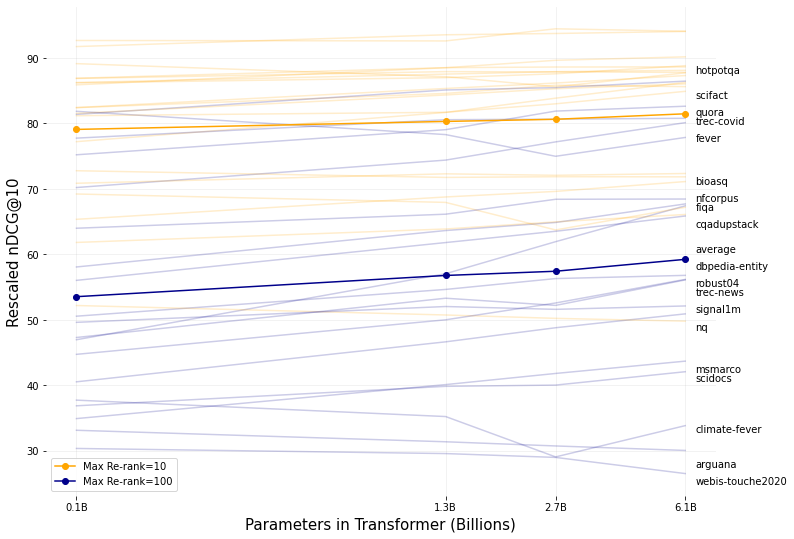

In [28]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Read NDCGS Json files

### Perfect BM25 scores
with open("./beir_perfect_rerank_10_ndcgs.json") as f:
    perf_bm25_10 = json.load(f)

with open("./beir_perfect_rerank_100_ndcgs.json") as f:
    perf_bm25_100 = json.load(f)

### GPT scores
with open("./beir_gptneo01_promptG_10_ndcgs.json") as f:
    gptneo01_10 = json.load(f)
with open("./beir_gptneo01_promptG_ndcgs.json") as f:
    gptneo01_100 = json.load(f)

with open("./beir_gptneo13_promptG_10_ndcgs.json") as f:
    gptneo13_10 = json.load(f)
with open("./beir_gptneo13_promptG_ndcgs.json") as f:
    gptneo13_100 = json.load(f)

with open("./beir_gptneo27_promptG_10_ndcgs.json") as f:
    gptneo27_10 = json.load(f)
with open("./beir_gptneo27_promptG_ndcgs.json") as f:
    gptneo27_100 = json.load(f)

with open("./beir_gptj_promptG_10_ndcgs.json") as f:
    gptj_10 = json.load(f)
with open("./beir_gptj_promptG_ndcgs.json") as f:
    gptj_100 = json.load(f)

### Rescaling

rerank_10_res = [gptneo01_10, gptneo13_10, gptneo27_10, gptj_10]
rerank_100_res = [gptneo01_100, gptneo13_100, gptneo27_100, gptj_100]

num_datasets = len(perf_bm25_10.keys())

y_ticks_num = [0, 20, 40, 60, 80, 100]
y_ticks = [str(num) for num in y_ticks_num]


for dataset in perf_bm25_10.keys():
    for res in rerank_10_res:
        for metric in res[dataset].keys():
            res[dataset][metric] = res[dataset][metric] / perf_bm25_10[dataset][metric]
            
            res.setdefault("average", {})
            res["average"].setdefault(metric, 0)
            res["average"][metric]  += res[dataset][metric] / num_datasets

    for res in rerank_100_res:
        for metric in res[dataset].keys():
            res[dataset][metric] = res[dataset][metric] / perf_bm25_100[dataset][metric]
            
            res.setdefault("average", {})
            res["average"].setdefault(metric, 0)
            res["average"][metric] += res[dataset][metric] / num_datasets


### Plotting


# Helper functions 

def base_round(val, base=2.5, digit=2):
    return base * round(val/base, digit)

def rescale(old_value, new_min=0.01, new_max=0.85):

    gpt_j_ndcgs = [gptj_100[x]["NDCG@10"] for x in gptj_100]

    old_min = min(gpt_j_ndcgs)
    old_max = max(gpt_j_ndcgs)

    new_value = (((old_value - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

    return new_value


fig, ax = plt.subplots(figsize=(12, 9),facecolor='w', edgecolor='k')

# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

model_xticks = ['0.1B', '1.3B','2.7B','6.1B']
model_xticks_num = [np.log2(125198592), np.log2(1315575808), np.log2(2651307520), np.log2(6053381344)]


for dataset in gptneo13_10.keys():

    alpha = 1 if dataset == "average" else 0.2
    marker = 'o' if dataset == "average" else None


    line_10, line_100 = [], []
    for res_10, res_100 in zip(rerank_10_res, rerank_100_res):
        line_10.append(res_10[dataset]["NDCG@10"] * 100)
        line_100.append(res_100[dataset]["NDCG@10"] * 100)

    plt.plot(model_xticks_num, line_10, label="Max Re-rank=10", color="orange", marker=marker, alpha=alpha)
    plt.plot(model_xticks_num, line_100, label="Max Re-rank=100", color="darkblue", marker=marker, alpha=alpha)



plt.ylabel("Rescaled nDCG@10", fontsize=15)

plt.xlabel("Parameters in Transformer (Billions)", fontsize=15)
plt.xticks(model_xticks_num, model_xticks)

# plt.title("Aggregate rescaled performance on BEIR")

# De-duplicate legend (https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


plt.grid(alpha=0.2)

vals = []

for i, dataset in enumerate(sorted(gptj_100, key=lambda x: gptj_100[x]["NDCG@10"]), start=1):

    ndcg_val = gptj_100[dataset]["NDCG@10"]
    
    # Automatically insert padding between texts
    ndcg_val = base_round(ndcg_val)
    while base_round(ndcg_val) in vals:
       ndcg_val = ndcg_val + 0.001
    vals.append(base_round(ndcg_val))

    # Rescale to appropriate x & y (Found via testing)
    plt.annotate(dataset, xy=(0.97, rescale(ndcg_val)), xycoords='axes fraction')

plt.show()

In [42]:
for i, dataset in enumerate(sorted(gptj_100, key=lambda x: gptj_100[x]["NDCG@10"]), start=1):
    plt.annotate(dataset, xy=(0.97, (1/num_datasets)*i), xycoords='axes fraction')

['hotpotqa',
 'scifact',
 'quora',
 'trec-covid',
 'fever',
 'bioasq',
 'nfcorpus',
 'fiqa',
 'cqadupstack',
 'average',
 'dbpedia-entity',
 'robust04',
 'trec-news',
 'signal1m',
 'nq',
 'msmarco',
 'scidocs',
 'climate-fever',
 'arguana',
 'webis-touche2020']

##### USEB graph

In [1]:
# Create kaggle dir -> Upload kaggle.json before executing the next cell
!kaggle

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [2]:
!mv kaggle.json /root/.kaggle/
!kaggle datasets download "muennighoff/usebzeroshotresults"
!unzip ./usebzeroshotresults.zip

!kaggle datasets download "muennighoff/useboodsupervisedresults"
!unzip ./useboodsupervisedresults.zip

  0% 0.00/162k [00:00<?, ?B/s]
100% 162k/162k [00:00<00:00, 10.8MB/s]
Archive:  ./usebzeroshotresults.zip
  inflating: SimCSE_poolout_layer-1_results_average_precision.json  
  inflating: SimCSE_poolout_layer-1_results_detailed.json  
  inflating: bert-base-uncased-cust_mean_layer-10_results_average_precision.json  
  inflating: bert-base-uncased-cust_mean_layer-10_results_detailed.json  
  inflating: bert-base-uncased-cust_mean_layer-11_results_average_precision.json  
  inflating: bert-base-uncased-cust_mean_layer-11_results_detailed.json  
  inflating: bert-base-uncased-cust_mean_layer-12_results_average_precision.json  
  inflating: bert-base-uncased-cust_mean_layer-12_results_detailed.json  
  inflating: bert-base-uncased-cust_mean_layer-13_results_average_precision.json  
  inflating: bert-base-uncased-cust_mean_layer-13_results_detailed.json  
  inflating: bert-base-uncased-cust_mean_layer-1_results_average_precision.json  
  inflating: bert-base-uncased-cust_mean_layer-1_result

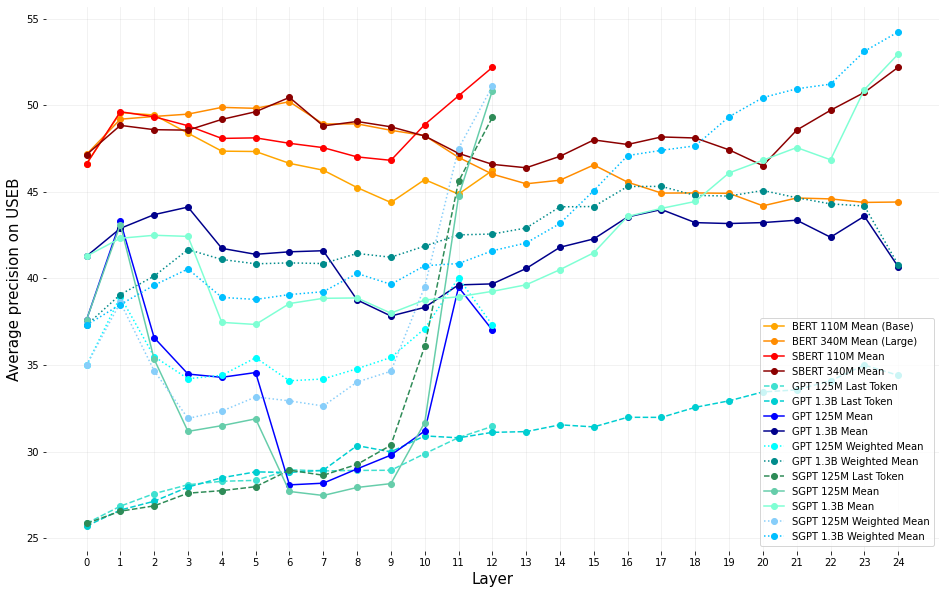

In [6]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt



bbase_mean_avgs = []
# Trained on NLI + STS
# sbbase_sts_mean_avgs = []
blarge_mean_avgs = []

sbbase_nli_mean_avgs = []
sblarge_nli_mean_avgs = []




mean01_avgs = []
mean13_avgs = []
lasttoken01_avgs = []

wmean01_avgs = []
wmean13_avgs = []
lasttoken13_avgs = []


sgpt01_mean_avgs = []
sgpt01_weightedmean_avgs = []
sgpt01_lasttoken_avgs = []

sgpt13_mean_avgs = []
sgpt13_weightedmean_avgs = []




for i in range(-25, 0, 1):


    if os.path.exists(f"./bert-base-uncased-cust_mean_layer{i}_results_average_precision.json"):
        with open(f"./bert-base-uncased-cust_mean_layer{i}_results_average_precision.json") as f:
            bbase_mean_res = json.load(f)
            bbase_mean_avgs.append(bbase_mean_res["avg"])

    with open(f"./bert-large-uncased-cust_mean_layer{i}_results_average_precision.json") as f:
        blarge_mean_res = json.load(f)
        blarge_mean_avgs.append(blarge_mean_res["avg"])


    if os.path.exists(f"./SBERT-base-nli-v2-cust_mean_layer{i}_results_average_precision.json"):
        with open(f"./SBERT-base-nli-v2-cust_mean_layer{i}_results_average_precision.json") as f:
            sbbase_nli_mean_res = json.load(f)
            sbbase_nli_mean_avgs.append(sbbase_nli_mean_res["avg"])

    # if os.path.exists(f"./SBERT-base-nli-stsb-v2-cust_mean_layer{i}_results_average_precision.json"):
    #    with open(f"./SBERT-base-nli-stsb-v2-cust_mean_layer{i}_results_average_precision.json") as f:
    #        sbbase_sts_mean_res = json.load(f)
    #        sbbase_sts_mean_avgs.append(sbbase_sts_mean_res["avg"])
    
    with open(f"./SBERT-large-nli-v2_mean_layer{i}_results_average_precision.json") as f:
        sblarge_nli_mean_res = json.load(f)
        sblarge_nli_mean_avgs.append(sblarge_nli_mean_res["avg"])




    if os.path.exists(f"./gpt01_mean_layer{i}_results_average_precision.json"):
        with open(f"./gpt01_mean_layer{i}_results_average_precision.json") as f:
            mean01_res = json.load(f)
            mean01_avgs.append(mean01_res["avg"])

    if os.path.exists(f"./gpt01_weightedmean_layer{i}_results_average_precision.json"):
        with open(f"./gpt01_weightedmean_layer{i}_results_average_precision.json") as f:
            wmean01_res = json.load(f)
            wmean01_avgs.append(wmean01_res["avg"])

    if os.path.exists(f"./gpt01_lasttoken_layer{i}_results_average_precision.json"):
        with open(f"./gpt01_lasttoken_layer{i}_results_average_precision.json") as f:
            lasttoken01_res = json.load(f)
            lasttoken01_avgs.append(lasttoken01_res["avg"])

    with open(f"./gpt13_mean_layer{i}_results_average_precision.json") as f:
        mean13_res = json.load(f)
        mean13_avgs.append(mean13_res["avg"])

    with open(f"./gpt13_weightedmean_layer{i}_results_average_precision.json") as f:
        wmean13_res = json.load(f)
        wmean13_avgs.append(wmean13_res["avg"])

    with open(f"./gpt13_lasttoken_layer{i}_results_average_precision.json") as f:
        lasttoken13_res = json.load(f)
        lasttoken13_avgs.append(lasttoken13_res["avg"])

    if os.path.exists(f"./SGPT-125M-mean-nli_mean_layer{i}_results_average_precision.json"):
        with open(f"./SGPT-125M-mean-nli_mean_layer{i}_results_average_precision.json") as f:
            sgpt01_mean_res = json.load(f)
            sgpt01_mean_avgs.append(sgpt01_mean_res["avg"])

    if os.path.exists(f"./SGPT-125M-weightedmean-nli_weightedmean_layer{i}_results_average_precision.json"):
        with open(f"./SGPT-125M-weightedmean-nli_weightedmean_layer{i}_results_average_precision.json") as f:
            sgpt01_weightedmean_res = json.load(f)
            sgpt01_weightedmean_avgs.append(sgpt01_weightedmean_res["avg"])

    if os.path.exists(f"./SGPT-125M-lasttoken-nli_lasttoken_layer{i}_results_average_precision.json"):
        with open(f"./SGPT-125M-lasttoken-nli_lasttoken_layer{i}_results_average_precision.json") as f:
            sgpt01_lasttoken_res = json.load(f)
            sgpt01_lasttoken_avgs.append(sgpt01_lasttoken_res["avg"])

    with open(f"./SGPT-1.3B-mean-nli_mean_layer{i}_results_average_precision.json") as f:
        sgpt13_mean_res = json.load(f)
        sgpt13_mean_avgs.append(sgpt13_mean_res["avg"])

    with open(f"./SGPT-1.3B-weightedmean-nli_weightedmean_layer{i}_results_average_precision.json") as f:
        sgpt13_weightedmean_res = json.load(f)
        sgpt13_weightedmean_avgs.append(sgpt13_weightedmean_res["avg"])



# Horizontal lines
with open(f"./gpt13_lasttokenmean_results_average_precision.json") as f:
    gpt13_ltm = json.load(f)

### PLOTTING

fig, ax = plt.subplots(figsize=(16, 10),facecolor='w', edgecolor='k')

model_xticks_num = list(range(0,25))

marker = 'o'

plt.plot(model_xticks_num[:len(bbase_mean_avgs)], bbase_mean_avgs, label="BERT 110M Mean (Base)", color="orange", marker=marker,)
plt.plot(model_xticks_num, blarge_mean_avgs, label="BERT 340M Mean (Large)", color="darkorange", marker=marker,)

plt.plot(model_xticks_num[:len(sbbase_nli_mean_avgs)], sbbase_nli_mean_avgs, label="SBERT 110M Mean", color="red", marker=marker,)
plt.plot(model_xticks_num, sblarge_nli_mean_avgs, label="SBERT 340M Mean", color="darkred", marker=marker,)

plt.plot(model_xticks_num[:len(lasttoken01_avgs)], lasttoken01_avgs, label="GPT 125M Last Token", color="turquoise", marker=marker, linestyle="dashed",)
plt.plot(model_xticks_num, lasttoken13_avgs, label="GPT 1.3B Last Token", color="darkturquoise", marker=marker, linestyle="dashed",)

plt.plot(model_xticks_num[:len(mean01_avgs)], mean01_avgs, label="GPT 125M Mean", color="blue", marker=marker,)
plt.plot(model_xticks_num, mean13_avgs, label="GPT 1.3B Mean", color="darkblue", marker=marker,)

plt.plot(model_xticks_num[:len(wmean01_avgs)], wmean01_avgs, label="GPT 125M Weighted Mean", color="cyan", marker=marker, linestyle="dotted",)
plt.plot(model_xticks_num, wmean13_avgs, label="GPT 1.3B Weighted Mean", color="darkcyan", marker=marker, linestyle="dotted",)

# Not too interesting
#plt.plot(model_xticks_num, [gpt13_ltm["avg"]] * len(model_xticks_num), label="GPT1.3B Last Token Layer Mean", color="green", linestyle="dashed",)

plt.plot(model_xticks_num[:len(sgpt01_lasttoken_avgs)], sgpt01_lasttoken_avgs, label="SGPT 125M Last Token", color="seagreen", marker=marker, linestyle="dashed",)

plt.plot(model_xticks_num[:len(sgpt01_mean_avgs)], sgpt01_mean_avgs, label="SGPT 125M Mean", color="mediumaquamarine", marker=marker,)
plt.plot(model_xticks_num, sgpt13_mean_avgs, label="SGPT 1.3B Mean", color="aquamarine", marker=marker,)

plt.plot(model_xticks_num[:len(sgpt01_weightedmean_avgs)], sgpt01_weightedmean_avgs, label="SGPT 125M Weighted Mean", color="lightskyblue", marker=marker, linestyle="dotted",)
plt.plot(model_xticks_num, sgpt13_weightedmean_avgs, label="SGPT 1.3B Weighted Mean", color="deepskyblue", marker=marker, linestyle="dotted",)


# Trained also on STS
# plt.plot(model_xticks_num[:len(sbbase_sts_mean_avgs)], sbbase_mean_avgs, label="SBERT Mean V2", color="yellow", marker=marker,)


# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.ylabel("Average precision on USEB", fontsize=15)
plt.xlabel("Layer", fontsize=15)

plt.xticks(model_xticks_num)

#plt.title("Average precision on USEB")
plt.legend()
plt.grid(alpha=0.2)


plt.show()

##### README scripts

In [2]:
!pip install -q transformers

     |████████████████████████████████| 3.5 MB 8.3 MB/s 
     |████████████████████████████████| 895 kB 50.5 MB/s 
     |████████████████████████████████| 67 kB 4.1 MB/s 
     |████████████████████████████████| 596 kB 52.3 MB/s 
     |████████████████████████████████| 6.8 MB 40.9 MB/s 


###### BE + SYM

In [3]:
import torch
from transformers import AutoModel, AutoTokenizer
from scipy.spatial.distance import cosine

# Get our models - The package will take care of downloading the models automatically
# For best performance: Muennighoff/SGPT-5.8B-weightedmean-nli-bitfit
tokenizer = AutoTokenizer.from_pretrained("Muennighoff/SGPT-125M-weightedmean-nli-bitfit")
model = AutoModel.from_pretrained("Muennighoff/SGPT-125M-weightedmean-nli-bitfit")

# Tokenize input texts
texts = [
    "deep learning",
    "artificial intelligence",
    "deep throating",
    "artificial snow",
]
batch_tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Get the embeddings
with torch.no_grad():
    # Get hidden state of shape [bs, seq_len, hid_dim]
    last_hidden_state = model(**batch_tokens, output_hidden_states=True, return_dict=True).last_hidden_state

# Get weights of shape [bs, seq_len, hid_dim]
weights = (
    torch.arange(start=1, end=last_hidden_state.shape[1] + 1)
    .unsqueeze(0)
    .unsqueeze(-1)
    .expand(last_hidden_state.size())
    .float().to(last_hidden_state.device)
)

# Get attn mask of shape [bs, seq_len, hid_dim]
input_mask_expanded = (
    batch_tokens["attention_mask"]
    .unsqueeze(-1)
    .expand(last_hidden_state.size())
    .float()
)

# Perform weighted mean pooling across seq_len: bs, seq_len, hidden_dim -> bs, hidden_dim
sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded * weights, dim=1)
sum_mask = torch.sum(input_mask_expanded * weights, dim=1)

embeddings = sum_embeddings / sum_mask

# Calculate cosine similarities
# Cosine similarities are in [-1, 1]. Higher means more similar
cosine_sim_0_1 = 1 - cosine(embeddings[0], embeddings[1])
cosine_sim_0_2 = 1 - cosine(embeddings[0], embeddings[2])
cosine_sim_0_3 = 1 - cosine(embeddings[0], embeddings[3])

print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[1], cosine_sim_0_1))
print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[2], cosine_sim_0_2))
print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[3], cosine_sim_0_3))

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/387 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

Cosine similarity between "deep learning" and "artificial intelligence" is: 0.692
Cosine similarity between "deep learning" and "deep throating" is: 0.460
Cosine similarity between "deep learning" and "artificial snow" is: 0.422


In [1]:
!pip install -q beir

     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 78 kB 4.6 MB/s 
     |████████████████████████████████| 8.6 MB 48.8 MB/s 
     |████████████████████████████████| 385 kB 59.6 MB/s 
     |████████████████████████████████| 4.9 MB 40.7 MB/s 
     |████████████████████████████████| 3.5 MB 31.6 MB/s 
     |████████████████████████████████| 6.8 MB 43.6 MB/s 
     |████████████████████████████████| 1.2 MB 48.8 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 895 kB 50.0 MB/s 
     |████████████████████████████████| 596 kB 52.4 MB/s 
     |████████████████████████████████| 497.5 MB 23 kB/s 
     |████████████████████████████████| 462 kB 47.5 MB/s 
     |████████████████████████████████| 15.7 MB 39.6 MB/s 
     |████████████████████████████████| 4.9 MB 44.2 MB/s 


In [2]:
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.0.0-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.0.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.0.0
# start server
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.0.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
import time
time.sleep(25)
# wait a bit then test - should show something like cluster_name" : "elasticsearch" ...
!curl -X GET "localhost:9200/"
from beir.retrieval.search.lexical import BM25Search as BM25
from beir.retrieval.evaluation import EvaluateRetrieval
#### Provide parameters for elastic-search
hostname = "localhost"
index_name = "toy"
initialize = True # True, will delete existing index with same name and reindex all documents
model = BM25(index_name=index_name, hostname=hostname, initialize=initialize)
retriever = EvaluateRetrieval(model)

curl: (7) Failed to connect to localhost port 9200: Connection refused


In [5]:
queries = {"0": "deep learning"}

corpus = {
    "1": {"text": "artificial intelligence",},
    "2": {"text": "deep throating",},
    "3": {"text": "artificial snow",},
}

#### Retrieve dense results (format of results is identical to qrels)
results = retriever.retrieve(corpus, queries,)

print("\n\nResults: ", results)

que: 100%|██████████| 1/1 [00:00<00:00, 95.49it/s]



Results:  {'0': {'2': 1.0296195}}


###### BE + ASYM

In [12]:
import torch
from transformers import AutoModel, AutoTokenizer
from scipy.spatial.distance import cosine

# Get our models - The package will take care of downloading the models automatically
# For best performance: Muennighoff/SGPT-5.8B-weightedmean-msmarco-specb-bitfit
tokenizer = AutoTokenizer.from_pretrained("Muennighoff/SGPT-125M-weightedmean-msmarco-specb-bitfit")
model = AutoModel.from_pretrained("Muennighoff/SGPT-125M-weightedmean-msmarco-specb-bitfit")

queries = [
    "I'm searching for a planet not too far from Earth.",
]

docs = [
    "Neptune is the eighth and farthest-known Solar planet from the Sun. In the Solar System, it is the fourth-largest planet by diameter, the third-most-massive planet, and the densest giant planet. It is 17 times the mass of Earth, slightly more massive than its near-twin Uranus.",
    "TRAPPIST-1d, also designated as 2MASS J23062928-0502285 d, is a small exoplanet (about 30% the mass of the earth), which orbits on the inner edge of the habitable zone of the ultracool dwarf star TRAPPIST-1 approximately 40 light-years (12.1 parsecs, or nearly 3.7336×1014 km) away from Earth in the constellation of Aquarius.",
    "A harsh desert world orbiting twin suns in the galaxy’s Outer Rim, Tatooine is a lawless place ruled by Hutt gangsters. Many settlers scratch out a living on moisture farms, while spaceport cities such as Mos Eisley and Mos Espa serve as home base for smugglers, criminals, and other rogues.",
]

SPECB_QUE_BOS = tokenizer.encode("[", add_special_tokens=False)[0]
SPECB_QUE_EOS = tokenizer.encode("]", add_special_tokens=False)[0]

SPECB_DOC_BOS = tokenizer.encode("{", add_special_tokens=False)[0]
SPECB_DOC_EOS = tokenizer.encode("}", add_special_tokens=False)[0]


def tokenize_with_specb(texts, is_query):
    # Tokenize without padding
    batch_tokens = tokenizer(texts, padding=False, truncation=True)   
    # Add special brackets & pay attention to them
    for seq, att in zip(batch_tokens["input_ids"], batch_tokens["attention_mask"]):
        if is_query:
            seq.insert(0, SPECB_QUE_BOS)
            seq.append(SPECB_QUE_EOS)
        else:
            seq.insert(0, SPECB_DOC_BOS)
            seq.append(SPECB_DOC_EOS)
        att.insert(0, 1)
        att.append(1)
    # Add padding
    batch_tokens = tokenizer.pad(batch_tokens, padding=True, return_tensors="pt")
    return batch_tokens

def get_weightedmean_embedding(batch_tokens, model):
    # Get the embeddings
    with torch.no_grad():
        # Get hidden state of shape [bs, seq_len, hid_dim]
        last_hidden_state = model(**batch_tokens, output_hidden_states=True, return_dict=True).last_hidden_state

    # Get weights of shape [bs, seq_len, hid_dim]
    weights = (
        torch.arange(start=1, end=last_hidden_state.shape[1] + 1)
        .unsqueeze(0)
        .unsqueeze(-1)
        .expand(last_hidden_state.size())
        .float().to(last_hidden_state.device)
    )

    # Get attn mask of shape [bs, seq_len, hid_dim]
    input_mask_expanded = (
        batch_tokens["attention_mask"]
        .unsqueeze(-1)
        .expand(last_hidden_state.size())
        .float()
    )

    # Perform weighted mean pooling across seq_len: bs, seq_len, hidden_dim -> bs, hidden_dim
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded * weights, dim=1)
    sum_mask = torch.sum(input_mask_expanded * weights, dim=1)

    embeddings = sum_embeddings / sum_mask

    return embeddings


query_embeddings = get_weightedmean_embedding(tokenize_with_specb(queries, is_query=True), model)
doc_embeddings = get_weightedmean_embedding(tokenize_with_specb(docs, is_query=False), model)

# Calculate cosine similarities
# Cosine similarities are in [-1, 1]. Higher means more similar
cosine_sim_0_1 = 1 - cosine(query_embeddings[0], doc_embeddings[0])
cosine_sim_0_2 = 1 - cosine(query_embeddings[0], doc_embeddings[1])
cosine_sim_0_3 = 1 - cosine(query_embeddings[0], doc_embeddings[2])

print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (queries[0], docs[0][:20] + "...", cosine_sim_0_1))
print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (queries[0], docs[1][:20] + "...", cosine_sim_0_2))
print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (queries[0], docs[2][:20] + "...", cosine_sim_0_3))

Cosine similarity between "I'm searching for a planet not too far from Earth." and "Neptune is the eight..." is: 0.568
Cosine similarity between "I'm searching for a planet not too far from Earth." and "TRAPPIST-1d, also de..." is: 0.494
Cosine similarity between "I'm searching for a planet not too far from Earth." and "A harsh desert world..." is: 0.406


###### CE + ASYM / SYM

In [15]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from scipy.spatial.distance import cosine

# Get models - The package will take care of downloading the models automatically
# For best performance: EleutherAI/gpt-j-6B
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")

prompt = 'Documents are searched to find matches with the same content.\nThe document "{}" is a good search result for "'

queries = [
    "I'm searching for a planet not too far from Earth.",
]

docs = [
    "Neptune is the eighth and farthest-known Solar planet from the Sun. In the Solar System, it is the fourth-largest planet by diameter, the third-most-massive planet, and the densest giant planet. It is 17 times the mass of Earth, slightly more massive than its near-twin Uranus.",
    "TRAPPIST-1d, also designated as 2MASS J23062928-0502285 d, is a small exoplanet (about 30% the mass of the earth), which orbits on the inner edge of the habitable zone of the ultracool dwarf star TRAPPIST-1 approximately 40 light-years (12.1 parsecs, or nearly 3.7336×1014 km) away from Earth in the constellation of Aquarius.",
    "A harsh desert world orbiting twin suns in the galaxy’s Outer Rim, Tatooine is a lawless place ruled by Hutt gangsters. Many settlers scratch out a living on moisture farms, while spaceport cities such as Mos Eisley and Mos Espa serve as home base for smugglers, criminals, and other rogues.",
]

for query in queries:
    print(f"Query: {query}")
    for doc in docs:
        context = prompt.format(doc)

        context_enc = tokenizer.encode(context, add_special_tokens=False)
        continuation_enc = tokenizer.encode(query, add_special_tokens=False)
        # Slice off the last token, as we take its probability from the one before
        model_input = torch.tensor(context_enc+continuation_enc[:-1])
        continuation_len = len(continuation_enc)
        input_len, = model_input.shape

        # [seq_len] -> [seq_len, vocab]
        logprobs = torch.nn.functional.log_softmax(model(model_input)[0], dim=-1).cpu()
        # [seq_len, vocab] -> [continuation_len, vocab]
        logprobs = logprobs[input_len-continuation_len:]
        # Gather the log probabilities of the continuation tokens -> [continuation_len]
        logprobs = torch.gather(logprobs, 1, torch.tensor(continuation_enc).unsqueeze(-1)).squeeze(-1)
        score = torch.sum(logprobs)
        # The higher (closer to 0), the better
        print(f"Document: {doc[:20] + '...'} Score: {score}")

Query: I'm searching for a planet not too far from Earth.
Document: Neptune is the eight... Score: -35.01509094238281
Document: TRAPPIST-1d, also de... Score: -35.89801025390625
Document: A harsh desert world... Score: -38.882957458496094


##### Compute Bias Parameters


In [ ]:
from transformers import AutoModelForCausalLM


# For some models lm_head & wte weights are tied, see https://github.com/huggingface/transformers/issues/14960

def count_params(module):
    return sum(p.numel() for p in module.parameters())

name = "gpt2"

model = AutoModelForCausalLM.from_pretrained(name, tie_word_embeddings=False)

print(f"Whole model: {count_params(model)}") 
print(f"Transformer: {count_params(model.transformer)}")
print(f"Head: {count_params(model.lm_head)}")

In [22]:
def get_params(model_name="Muennighoff/SGPT-125M-weightedmean-nli-bitfit"):
    from transformers import AutoModel
    model = AutoModel.from_pretrained(model_name)
    bias_params = 0
    total_params = 0
    for name, param in model.named_parameters():
        nn = 1
        for s in list(param.size()):
            nn = nn*s
        total_params += nn
        if "bias" in name:
            print(name)
            bias_params += nn
    print("Total: ", total_params)
    print("Bias: ", bias_params)
    print("%: ", (bias_params / total_params) * 100)

In [23]:
get_params("Muennighoff/SBERT-base-nli-v2-bitfit")

embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.bias
encoder.layer.1.attention.self.value.bias
encoder.layer.1.attention.output.dense.bias
encoder.layer.1.attention.output.LayerNorm.bias
encoder.layer.1.intermediate.dense.bias
encoder.layer.1.output.dense.bias
encoder.layer.1.output.LayerNorm.bias
encoder.layer.2.attention.self.query.bias
encoder.layer.2.attention.self.key.bias
encoder.layer.2.attention.self.value.bias
encoder.layer.2.attention.output.dense.bias
encoder.layer.2.attention.output.LayerNorm.bias
encoder.layer.2.intermediate.dense.bias
encoder.layer.2.output.dense.bias
encoder.layer.2.output.Layer